#INTRODUCCIÓN (AÑADIR)

El objetivo principal nuestro proyecto es implementar el descriptor SIFT desde cero y estudiar distintos clasificadores. SIFT aplicado a una imagen dada, devuelve un conjunto de descriptores, cada descriptor consiste en un vector de $128$ elementos. Por otro lado, los clasificadores que vamos a considerar son:

- SIFT + Bow: (Mirar 3.3.BoW_Blobs, diap 31). Con SIFT realizamos el primer paso, obtener los descriptores. Posteriormente deberíamos hacer clustering y determinar las frecuencias. Posteriormente podemos calcular la matriz de distancias y aplicar un algoritmo de SVM ( [pdf](https://www.di.ens.fr/willow/events/cvml2011/materials/CVML2011_Cordelia_bof.pdf))

- SIFT + Neural Network (Machine Learning usando SIFT como preprocesado ). Hay que ver exactamente a donde llegar con el preprocesado. Una imagen puede tener 100 descriptores, cada uno con 128 elementos, nos montamos en 12800 valores para cada imagen. Entrenar una red neuronal con esos parametros de entrada puede ser una locura? Otra opción podría ser aplicar la red a los cluster encontrados en el BoW.

- Deep Learning con CNN: Simular lo hecho en la P2


# CÓDIGO FUNDAMENTAL (PERFILAR, REVISAR, ...)

In [97]:
# We start by getting access to the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [98]:
# We import the modules to use
import os,sys
import cv2, numpy as np, math
from matplotlib import pyplot as plt
import math as mt
# change directory
%cd '/content/drive/My Drive'
#  the current directory
%pwd

# This allows to display images  and to save  them in cells
%matplotlib inline
# this definition allows to read files in a specific path
get_image = lambda route: os.path.join('/content/drive/My Drive/images', route)

/content/drive/My Drive


In [99]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im has three-channels
    plt.imshow(im, cmap='jet')
  else:
    # im has a single-channel
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([])
  plt.show()

'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

In [100]:
def GaussFunc(x,sigma):
  resultado = [math.exp(-(i**2)/(2*sigma**2)) for i in x]
  return resultado

def GaussDeriv1Func(x,sigma):
  resultado = [(-i/sigma**2)*math.exp(-(i**2)/(2*sigma**2)) for i in x]
  return resultado

def GaussDeriv2Func(x,sigma):
  resultado = [-(1/(sigma**2)-(i**2)/(sigma**4))*math.exp(-(i)**2/(2*sigma**2)) for i in x]
  return resultado


def gaussianMask1D(sigma=0, sizeMask=0, order=0):
  #Cálculo de parámetros
  if sizeMask == 0 and sigma > 0:
    sizeMask = (2*math.ceil(3*sigma)) + 1
  elif sizeMask > 1 and sigma == 0:
    sigma = (sizeMask - 1)/6
  else:
    print('Error en los parámetros. COMPLETARRRR')
    return 0 #Esta bien???

  #Creamos el dominio
  m = (sizeMask - 1)/2
  domain = np.linspace(-m, m, num = sizeMask)

  if order == 0:
    mask = GaussFunc(domain, sigma)
    mask = np.array(mask)

    #Normalizmaos para que la suma sea 1
    sum = 0
    for i in range(sizeMask):
      sum = sum + mask[i]
    for i in range(sizeMask):
      mask[i] = mask[i]/sum

  elif order == 1:
    mask = GaussDeriv1Func(domain, sigma)
    mask = np.array(mask)
    mask = mask*sigma

  elif order == 2:
    mask = GaussDeriv2Func(domain, sigma)
    mask = np.array(mask)
    mask = mask*(sigma*sigma)

  return mask


def my2DConv(im, sigma, orders):
  ddepth=cv2.CV_64F
  maskG=gaussianMask1D(sigma, order=0)
  maskDG=gaussianMask1D(sigma, order=1)
  mask2DG= gaussianMask1D(sigma, order=2)
  if orders==[0,0]: # Suavizado Gaussiano
    return cv2.sepFilter2D(im, ddepth, kernelX=np.array(maskG), kernelY=np.array(maskG))
  elif orders==[1,0]: # Diferenciacion horizontal
    return cv2.sepFilter2D(im, ddepth, kernelX=np.array(maskDG), kernelY=np.array(maskG))
  elif orders==[2,0]:
    return cv2.sepFilter2D(im, ddepth, kernelX=np.array(mask2DG), kernelY=np.array(maskG))
  elif orders==[0,1]: # Diferenciacion vertical
    return cv2.sepFilter2D(im, ddepth, kernelX=np.array(maskG), kernelY=np.array(maskDG))
  elif orders==[0,2]:
    return cv2.sepFilter2D(im, ddepth, kernelX=np.array(maskG), kernelY=np.array(mask2DG))
  else:
    print('error in order of derivative')

'''
This function displays a pyramid of images, providing as input the list of images to display.

Example of usetw:
im1=readIm(get_image('apple.jpg'),1)
images = [im1, cv2.resize(im1,(im1.shape[0]//2,im1.shape[1]//2),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//4,im1.shape[1]//4),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//8,im1.shape[1]//8),cv2.INTER_LINEAR), cv2.resize(im1,(im1.shape[0]//16,im1.shape[1]//16),cv2.INTER_LINEAR)]

displayPyramid(images, title='Piramide de Manzanas')

'''
def displayPyramid(vim, title='result'):
  temp = np.zeros_like(vim[0])
  if np.mod(temp.shape[1],2)==0:
    h = temp[:, :temp.shape[1]//2]
  else:
    h = temp[:, :(temp.shape[1]//2)+1]
  out = np.hstack((temp, h))
  top = 0
  out[0:vim[0].shape[0], 0:vim[0].shape[1]] = vim[0]
  left = vim[0].shape[1]
  for i in range(1, len(vim)):
    out[top:top+vim[i].shape[0], left:left + vim[i].shape[1]] = vim[i]
    top += vim[i].shape[0]
  displayIm(out, title)

Leamos una imagen con la que trabajaremos

In [101]:
im=cv2.imread(get_image('IMG_20211030_110410_S.jpg'),0)
print(im.shape[0], im.shape[1])

300 400


# EL DESCRIPTOR SIFT

SIFT (Scale invariant feature transform) obtiene un conjunto de descriptores de una imagen los cuales son invariantes a traslaciones, rotaciones y escalado de dicha imagen.

Debido a la robustez de los descriptres devueltos por el algoritmo, esta técina suele utilizarse para emparejamiento de imágenes, detección de objetos o estabilización de video entre otros.

El algoritmo esta compuesto de dos operaciones. Primero se detectan los puntos clave, *keypoints*, y posteriormente se extrae un descriptor asociado a cada *keypoint*.



# 1. EL ESPACIO DE ESCALAS GAUSSIANO

Definimos el espacio de escalas como una familia paramétrica de imágenes suavizadas, $\{I_{\sigma_i} : \sigma_i \in \Sigma \}$, siendo $\sigma_i$ la desviación típica que posee la imagen y $\Sigma$ el espacio paramétrico.
Usaremos el espacio de escalas como una herramienta para facilitar el análisis de la imagen en cuestión, este se fundamenta en conceptos físicos y biológicos relacionados con la visión.

### SUAVIZADO GAUSSIANO



Recordemos que para dos variables aleatorias $X$, $Y$ independientes que siguen una distribución normal $\mathcal{N}(0, \sigma_X)$ y $\mathcal{N}(0, \sigma_Y)$ con $F_X$ y $F_Y$ sus funciones de distribución respectivamente, se cumple que la variable aleatoria $X +Y$ tiene la función de distribución:

$$ F_{X+Y} = F_{X}*F_{Y}$$


Por otro lado, cualquier variable aleatoria viene dada univocamente por su función de densidad, y por ende, su función de distribución. Luego a toda función de densidad (función de distribución) le corresponde una única variable aleatoria.

Consideramos entonces una imagen continua $u:\mathbb{R}^2 \rightarrow \mathbb{R}$ y definimos el suavizado continuo como la convolución

$$(G_{\sigma}*u)(x) = \int_{-\infty}^{\infty }G_{\sigma} (\xi)u(x - \xi) d\xi $$

siendo

$$G_{\sigma}(x)= \frac{1}{\sqrt{2\pi}\sigma}\cdot e^\frac{-\|x\|^2}{2\cdot \sigma^2}$$

con $x$ un vector de $\mathbb{R}^2$. Podemos entonces identificar cada filtro Gaussiano con su respectiva variable aleatoria $X_{\sigma} \sim \mathcal{N}(0, \sigma)$.

Componiendo dos filtros gaussianos $(G_{\sigma_1} * (G_{\sigma_2} * u))(x)$, que es equivalente a $((G_{\sigma_1} * G_{\sigma_2}) * u)(x)$ por la linealidad de la convolución, podemos asociar este nuevo filtro a la variable aleatoria $X_{\sigma_1}+X_{\sigma_2}$ siendo $X_{\sigma_1}$ y $X_{\sigma_2}$ variables independientes. Por lo tanto:

$$Var[X_{\sigma1} + X_{\sigma_2}] =  Var[X_{\sigma_1}] + Var[X_{\sigma_2}] = \sigma_1^2 + \sigma_2^2$$

y la desviación típica asociada a esta nueva variable es

$$\sigma_{1,2} = \sqrt{\sigma_1^2 + \sigma_2^2}$$

Luego las funciones Gaussianas son cerradas para la convolución, la cual es una operación asociativa. Esto nos da que los operadores de filtro Gaussiano satisfacen una estructura de semigrupo con la operación:

$$G_{\sigma_1} * G_{\sigma_2} = G_{\sqrt{\sigma_1^2+\sigma_2^2}}$$

Podemos entonces ver el espacio de escalas Gaussiano como la función $\nu$ de tres variables

$$\nu:(\sigma, x ) \rightarrow (G_{\sigma}*u)(x)$$

### ESPACIO DE ESCALAS GAUSSIANO DIGITAL



Nuestro espacio de escalas contiene en la posición $(\sigma,x)$ el valor que toma la imagen $u$ asociada a $\sigma$ en el píxel $x$. Nuestro objetivo ahora es discretizar este espacio.


Vamos a organizar nuestro espacio de escalas en octavas, tendremos $n_o$ de estas. Cada octava tendrá un mismo número de escalas, $n_{spo}$. Trataremos más adelante con las escalas, por ahora simplemente considerémoslas como las imágenes donde buscaremos nuestras características.

Dentro de cada octava $o$ consideramos el concepto de distancia entre píxeles $\delta_o$. Este indica la distancia que medimos en la imagen de entrada para dos píxeles adyacentes en cualquier imagen de la octava, es decir, si en la primera octava hacemos un *upsampling* $\times 2$, dos píxeles adyacentes en esta octava se encontrarán dentro del mismo pixel en la imagen de entrada, luego la distancia entre píxeles será $\delta_0 = 0.5$. Es natural considerar la distancia entre píxeles inicial como $\delta_{in} = 1$.

Supongamos que nuestra imagen de entrada $u_{in}$ contiene un suavizado $\sigma_{in}$. Partimos entonces tomando una imagen semilla con una desviación típica $\sigma_{in}$, esta imagen la calcularemos a partir de $u_{min}$  y se encontrará en la primera octava, luego tendrá una distancia entre píxeles $\delta_0 = \delta_{min} = 0.5$.

Por otro lado, empezaremos realizando un aumento a nuestra imagen de factor de $2$ y seguiremos con reducciones con el mismo factor, luego $\delta_{min} = 0.5$ y

$$\delta_o = \delta_{min}2^\frac{c}{n_{spo}}$$

Recordemos que el objetivo es que nuestro espacio de escalas tenga $n_o$ octavas, cada una con $n_{nos}$ escalas. Sin embargo, al comienzo cada octava contendra $n_{spo} + 3$ imágenes, que denotaremos por $v_i^o$, estas $3$ imágenes extra cobrarán sentido más adelante.

Queremos entonces pasar de una desviación típica $\sigma_{in}$ a una desviación típica $\sigma_{min}$, luego aplicando la estructura de semigrupo de la gaussiana obtenemos

$$\sigma_{min}^2 = \sigma^2 + \sigma_{in}^2 \quad \Rightarrow \quad \sigma  = \sqrt{ \sigma_{min}^2 - \sigma_{in}^2 }$$

luego obtenemos nuestra imagen semilla como

$$v_0^0 = G_{\frac{1}{\delta_{min}} \sqrt{\sigma_{min}^2 - \sigma_{in}^2}} * I_{\delta_{min}}(u_{in})$$

siendo $I_{\delta_{min}}$ la interpolaciṕon bilineal con un factor de $\frac{1}{\delta_{min}}$. Observemos como la máscara gaussiana se adapta al factor de interpolación.


A la hora de establecer las desviaciones típicas debemos tener en cuenta que, cada vez que pasamos de octava, nuestro $\sigma$ debe duplicarse. Luego podemos considerar que dentro de cada octava, la desviación típica que debe contener cada imagen viene dada por

$$ \sigma_s =  \sigma_{min}2^{\frac{s}{n_{spo}}}$$

Si le añadimos el factor de la distancia entre píxeles tenemos que

$$ \sigma_s^o =  \frac{\delta_{0}}{\delta_{min}}\sigma_{min}2^{\frac{s}{n_{spo}}} $$

Pero como queremos que sea independiente de cada octava, ya que el facor $\delta_{0}$ lo obtenemos al hacer el *subsamplig*, nos quedamos con

$$ \sigma_s =  \frac{\sigma_{min}}{\delta_{min}}2^{\frac{s}{n_{spo}}} \quad$$

Entonces, a partir de la primera imagen de la octava podemos crear las siguientes de forma recursiva simplemente aplicando

$$v_s^o = G_{\rho [(s-1) \rightarrow s]}* v^o_{s-1}$$

donde

$$\rho [(s-1) \rightarrow s] = \sqrt{\sigma_s^2 - \sigma_{s-1}^2}
= \sqrt{\left( \frac{\sigma_{min}}{\delta_{min}}2^{\frac{s}{n_{spo}}} \right)^2 - \left( \frac{\sigma_{min}}{\delta_{min}}2^{\frac{s-1}{n_{spo}}} \right)^2}$$

$$= \frac{\sigma_{min}}{\delta_{min}}\sqrt{2^{\frac{2s}{n_{spo}}} - 2^{\frac{2(s-1)}{n_{spo}}}}$$

La primera imagen de cada octava la calculamos como

$$v_0^o = S_2 v_{n_{spo}}^{o-1} $$

siendo $S_2$ el operador de *subsamplig* de factor $2$.

Con estas fórmulas ya estamos en condiciones de crear el espacio de escalas Gaussiano, que como hemos podido observar, depende de 5 parámetros:

- El número de octavas: $n_{o}$ ($=5$ por defecto)
- El número de escalas por octava: $n_{spo}$ ($=3$ por defecto)
- La distancia enter píxeles mínima: $\delta_{min}$ ($=0.5$ por defecto)
- La desviación típoca mínima: $\sigma_{min}$ ($=0.8$ por defecto)
- La desviación típica asumida en la imagen de entrada: $\sigma_{in}$ ($=0.5$ por defecto)


In [102]:
def scaleSpace(input_image, noct=5, nspo=3, pixel_distance_min=0.5, sigma_min=0.8, sigma_input=0.5):
    """
    Construye un espacio de escalas a partir de una imagen de entrada.

    Parámetros:
    - input_image: La imagen de entrada.
    - noct: Número de octavas en el espacio de escalas (predeterminado: 5).
    - nspo: Número de escalas por octava (predeterminado: 3).
    - pixel_distance_min: Distancia mínima en píxeles entre dos puntos en la imagen (predeterminado: 0.5).
    - sigma_min: Valor mínimo de sigma (predeterminado: 0.8).
    - sigma_input: Valor de sigma para la imagen de entrada (predeterminado: 0.5).

    Salida:
    - Una lista que representa el espacio de escalas construido.
    """

    ddepth = cv2.CV_64F


    # Redimensiona la imagen de entrada a 256x256 píxeles en nuestro caso.
    im = cv2.resize(input_image, (256, 256), cv2.INTER_LINEAR)

    # Define el número de columnas en la matriz de escalas como el número de escalas por octava más tres.
    column = nspo + 3

    # Inicializa las variables para almacenar los valores de sigma y las máscaras Gaussianas.
    rho = np.zeros(column - 1)
    maskGaussian = []

    # Calcula sigma_zero usando los parámetros proporcionados.
    sigma_zero = sigma_min / pixel_distance_min

    # Calcula los valores de sigma y crea las máscaras Gaussianas correspondientes para cada escala.
    for s in range(column - 1):
        rho[s] = sigma_zero * mt.sqrt(2 ** ((2 * (s + 1)) / nspo) - 2 ** ((2 * s) / nspo))
        maskGaussian.append(gaussianMask1D(rho[s], 0, order=0))

    # Inicializa el espacio de escalas como una lista vacía.
    scale_space = []

    # Crea la semilla para el espacio de escalas doblando el tamaño de la imagen y aplicando un suavizado Gaussiano.
    seed = cv2.resize(im, (round(im.shape[1] * 2), round(im.shape[0] * 2)), cv2.INTER_LINEAR)
    rho_ini = (1 / pixel_distance_min) * np.sqrt(sigma_min ** 2 - sigma_input ** 2)
    maskG = gaussianMask1D(rho_ini, 0, order=0)
    seed = cv2.sepFilter2D(seed, ddepth, kernelX=np.array(maskG), kernelY=np.array(maskG))

    # Crea la primera octava suavizando la semilla con las máscaras Gaussianas.
    initial_octave = [seed]
    for s in range(column - 1):
        new_im = cv2.sepFilter2D(initial_octave[-1], ddepth, kernelX=np.array(maskGaussian[s]), kernelY=np.array(maskGaussian[s]))
        initial_octave.append(new_im)
    scale_space.append(initial_octave)

    # Crea las octavas restantes reduciendo a la mitad la última imagen de la octava anterior y suavizándola.
    for i in range(noct - 1):
        new_octave = []
        new_im = cv2.resize(scale_space[-1][3], (round(scale_space[-1][3].shape[1] / 2), round(scale_space[-1][3].shape[0] / 2)), cv2.INTER_LINEAR)
        new_octave.append(new_im)

        for s in range(column - 1):
            new_im = cv2.sepFilter2D(new_octave[-1], ddepth, kernelX=np.array(maskGaussian[s]), kernelY=np.array(maskGaussian[s]))
            new_octave.append(new_im)

        scale_space.append(new_octave)

    return scale_space

Con estos valores iniciales las desviaciones típicas que tenemos que aplicar a cada escala son:

$$\{ 1.22, 1.54, 1.94, 2.45, 3.09\}$$

Comprobemos el funcionamiento de la función con la imagen que hemos tomado.


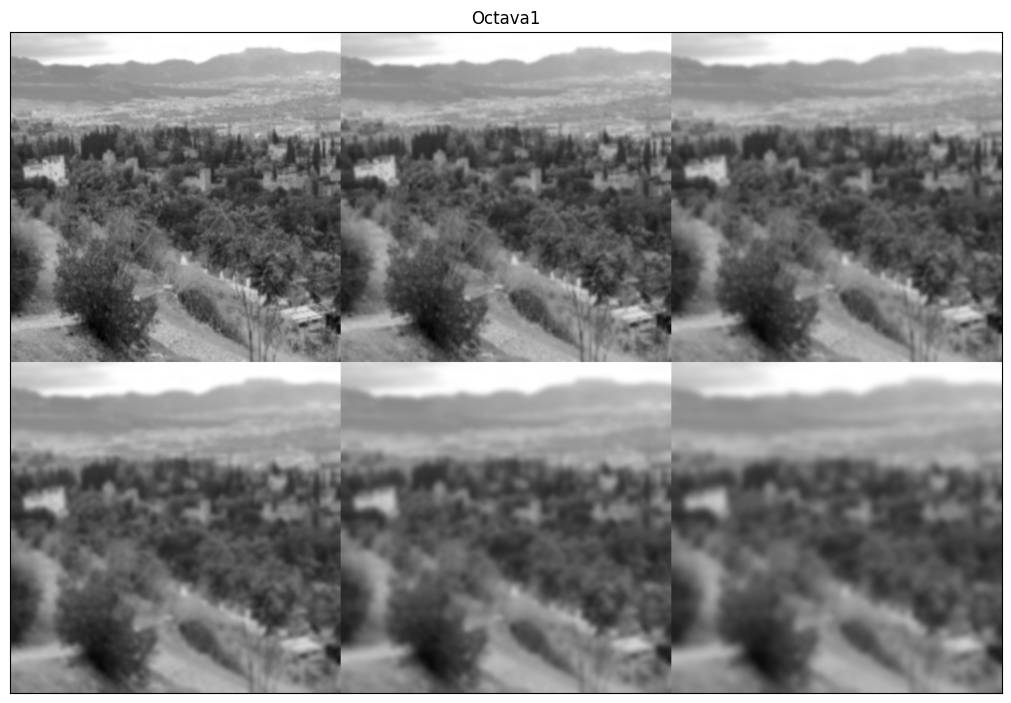

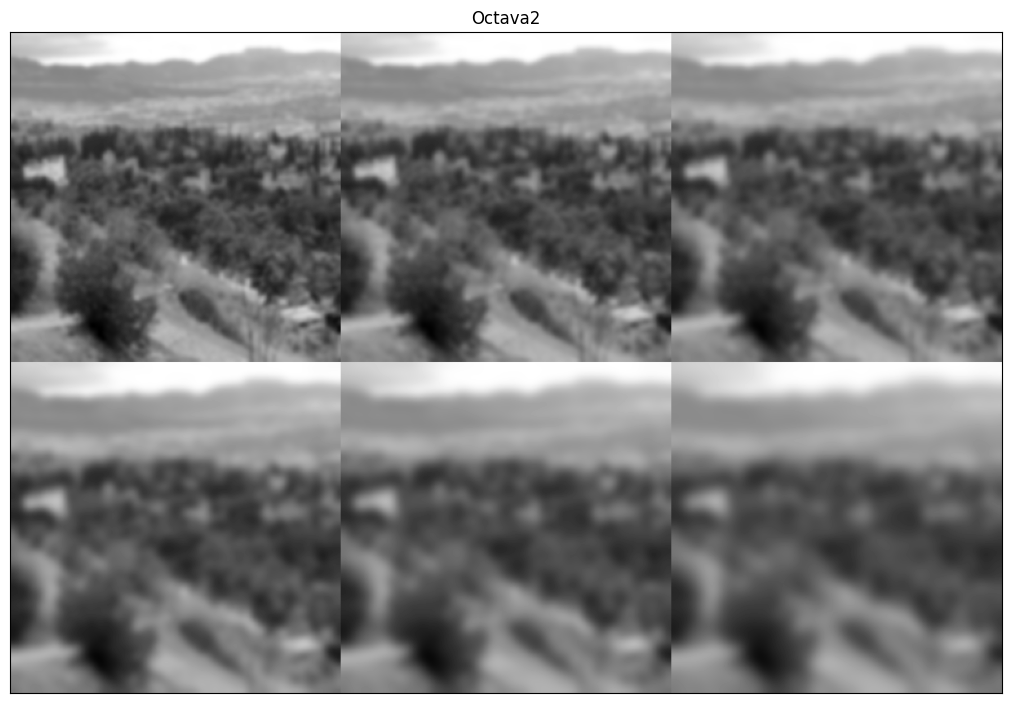

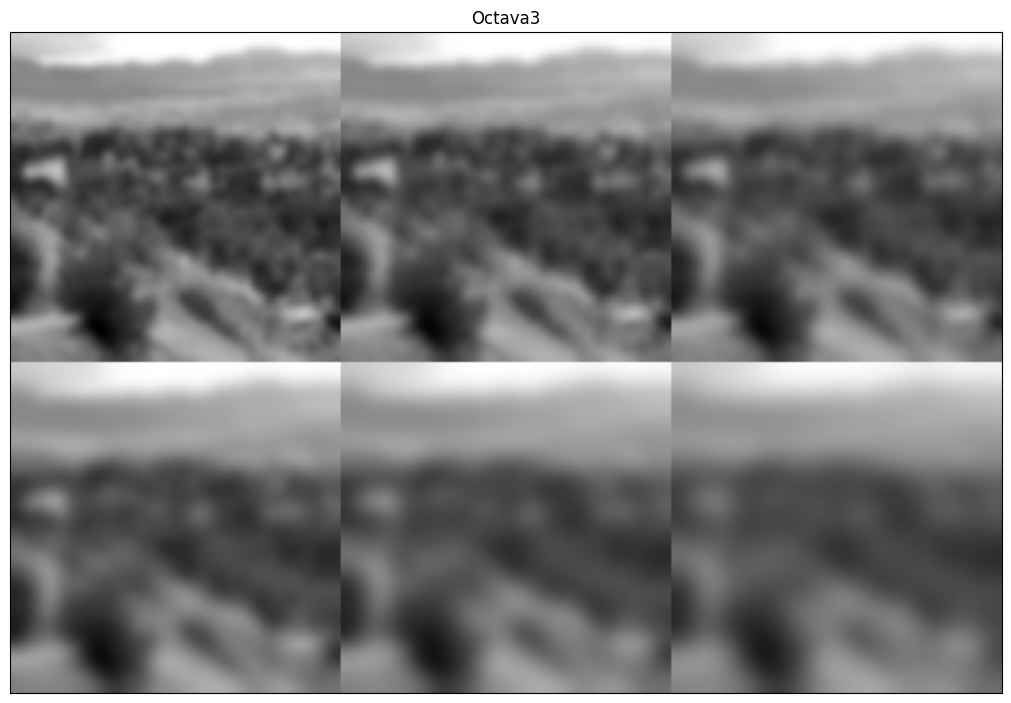

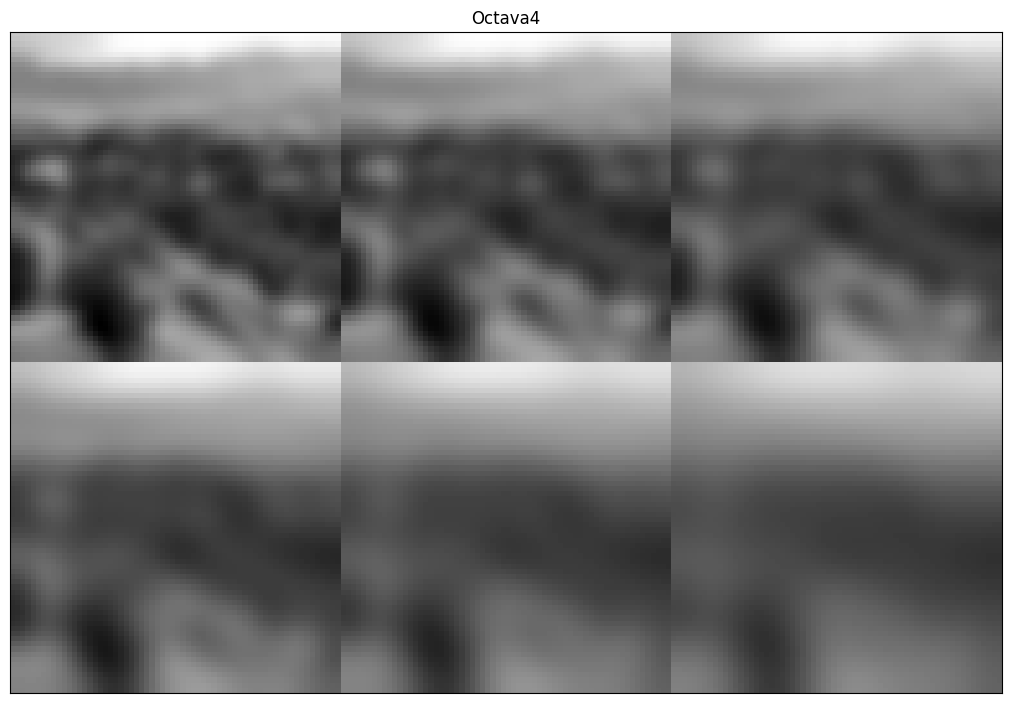

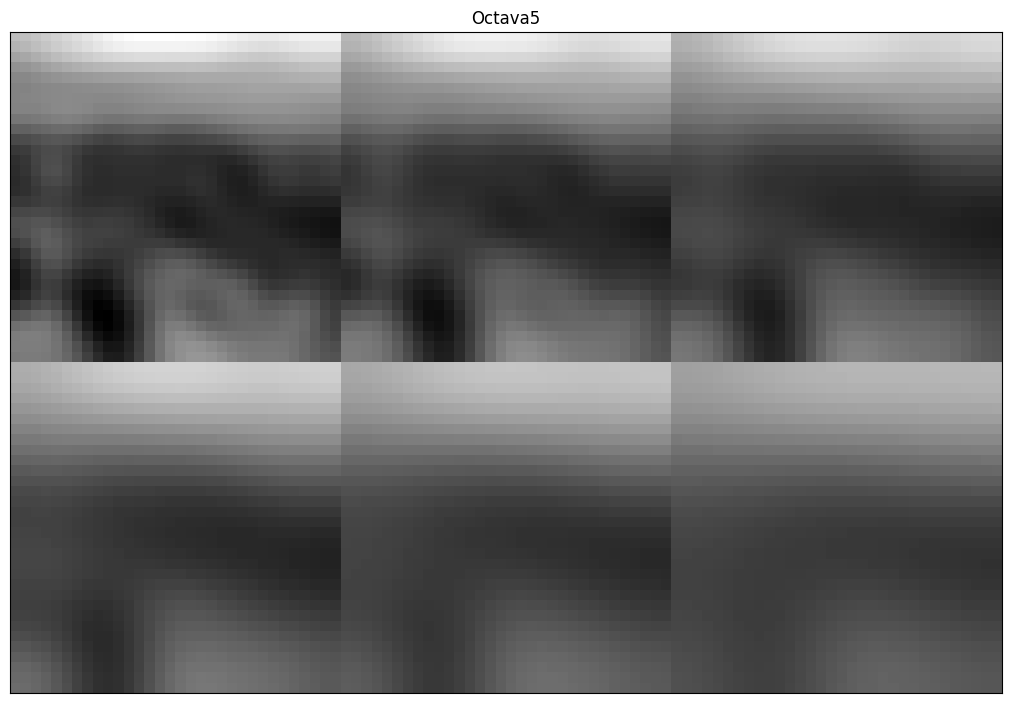

In [103]:
scale_space = scaleSpace(im)

for i in range(len(scale_space)):
  displayMI_ES(scale_space[i], 'Octava' + str(i+1))

Como vemos, hemos obtenido el resultado deseado.

# 2. ANÁLISIS DEL ESPACIO DE ESCALAS GAUSSIANO

Nuestro siguiente paso es detectar los *keypoints* de nuestra imagen original que, en nuestro algoritmo los definiremos como los extremos de las escalas de nuestro espacio de escalas Laplaciano normalizado. Un extremo Laplaciano está univocamente caracterizado por sus coordenadas en el espacio de escalas $(\sigma,x)$.

En nuestro espacio de escalas Laplaciano cada nivel contiene un registro de frecuencias que viene dado por la desviación típica, luego el parámetro $\sigma$ nos dice indirectamente en que frecuencias tenemos nuestro extremo.

Con el objetivo de mejorar el rendimiento, en lugar de calcular la Laplaciana de cada imagen, optamos por calcular la diferencia de Gaussianas. La diferencia de Gaussianas (DoG) de orden $k$ es definida como $w:(\sigma,x) \rightarrow v(k\sigma,x) - v(\sigma,x)$.


Sabemos que para una función $u \in C(\mathbb{R}^n)$, tal que $u:(\cdot,t) \rightarrow \mathbb{R}$, la ecuación del calor viene dada por

$$\frac{\partial u}{\partial t} = \Delta u$$

y que, la solución fundamental (o kernel del calor) de esta ecuación es

$$G(t,x,y) = \frac{1}{(4\pi t)^{\frac{d}{2}}}e^{\frac{-\| x - y\|^2}{4t}}$$

tomando $y= \mu$ y $\sqrt{2t} = \sigma$ tenemos nuestro filtro gaussiano (siempre consideramos la variable centrada, $\mu = 0$). Aprovechando esta relación con la ecuación de calor tenemos la aproximación:

$$\sigma \Delta v = \frac{\partial v}{\partial \sigma} \approx \frac{v(k\sigma,x)-v(\sigma,x)}{k\sigma-\sigma}=\frac{w(\sigma,x)}{(k-1)\sigma}$$

y tenemos asi que $w(\sigma,x)\approx (k-1)\sigma^2\Delta v(\sigma,x)$.Como vemos, teoricamente, la mejor aproximación que hacemos de la Laplaciana es cuando

$$(k-1)\sigma^2 = 1 \Rightarrow k = \frac{1}{\sigma^2} + 1$$

Sin embargo, como simplemente nos interesa calcular la Laplaciana para la búsqueda de extremos, la proporción de esta no nos será de especial interés.

Tenemos así que, para construir el espacio de escalas Laplaciano $w$ procedemos de la siguiente manera. Para cada octava $o \in \{1, ..., n_o \}$ se calculan las imágenes $w_s^o(n,m) = v_{s+1}^o(n,m) - v_s^o(n,m)$ con $s \in \{0,...,n_{spo}+1\}$. La imagen $w_s^o$ estará asociada al nivel de suavizado $\sigma_s^o$.

Podemos observar como ahora cobran sentido las 3 imágenes que hemos añadido a nuestro espacio de escalas Gaussiano, la última sirve para generar la última Laplaciana, y tenemos $2$ Laplacianas más que el número de escalas porque las usaremos a continuación para encontrar los máximos.

Vamos a definir una función para calcular el espacio de escalas Laplaciano.

In [104]:
def laplacianSpace(scale_space):
  """
  Calcula el espacio laplaciano a partir del espacio de escala.

  Parámetros:
  - scale_space: Un arreglo multidimensional que contiene los datos del espacio de escala.

  Salida:
  - Una lista de listas que representa el espacio laplaciano.
  """
  # Control de errores
  laplacian_space = []

  # Número de octavas en el espacio de escala.
  noct = len(scale_space)

  # Número de columnas en cada octava (escala).
  columns = len(scale_space[0]) - 1

  # Iterar a través de las octavas y calcular las diferencias entre las escalas.
  for i in range(noct):
    laplacian_octave = []

    # Calcular las diferencias para cada columna en la octava.
    for j in range(columns):
      laplacian_octave.append(scale_space[i][j + 1] - scale_space[i][j])

    # Agregar la octava calculada al espacio laplaciano.
    laplacian_space.append(laplacian_octave)

  # Retorna el espacio laplaciano resultante.
  return laplacian_space

Vamos a calcular el espacio Laplaciano y a imprimirlo para comprobar su funcionamiento

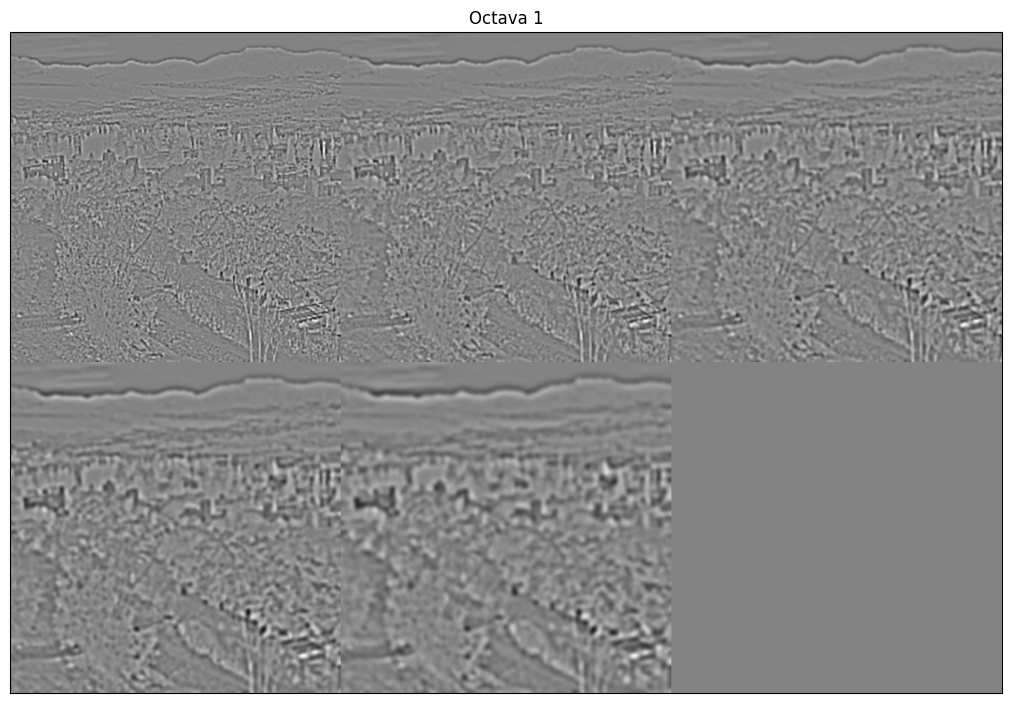

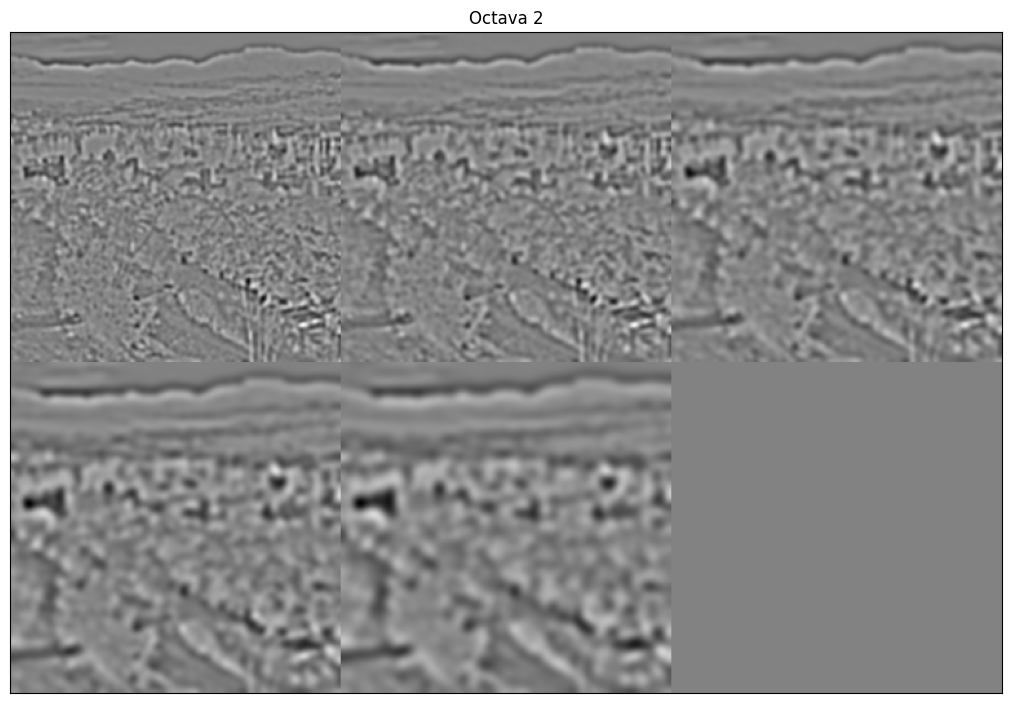

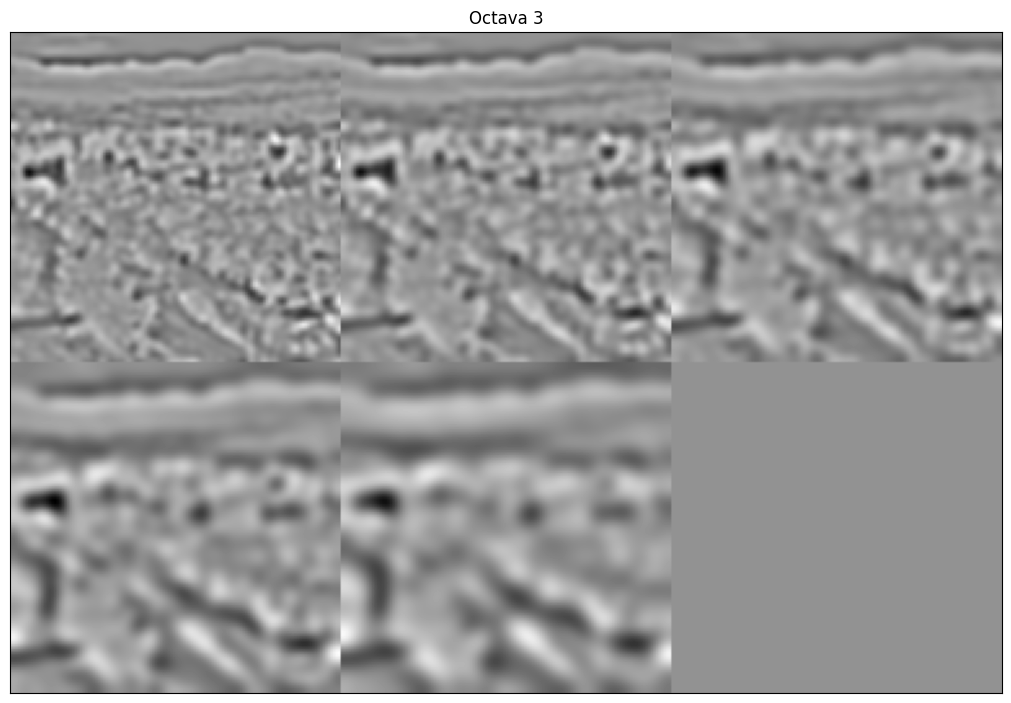

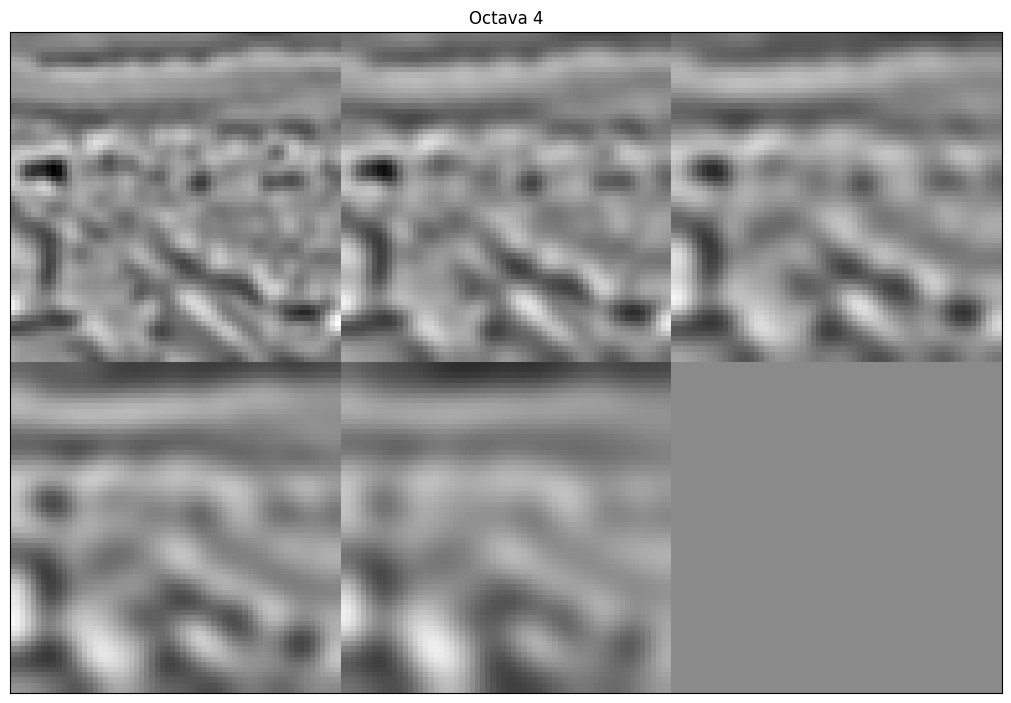

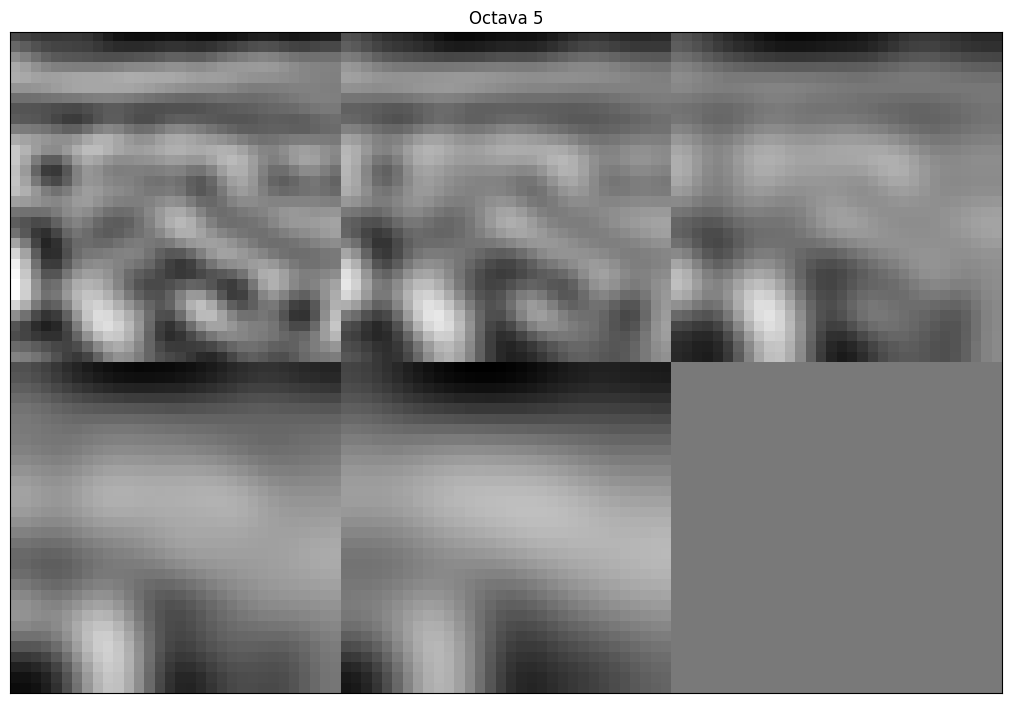

In [105]:
# Cálculo del espacio Laplaciano
laplacian_space = laplacianSpace(scale_space)

for i in range(len(laplacian_space)):
  displayMI_ES(laplacian_space[i], 'Octava ' + str(i+1))


# 3. EXTRACCIÓN DE KEYPOINTS CANDIDATOS

### DETECCIÓN DE EXTREMOS



Para extraer los extremos tomamos cada valor de nuestro espacio de escalas laplaciano $w^o_s(m,n)$ con $s = 1, ..., n_{spo}$, $o = 1,..., n_o$, $m=1,...,M_o-2$  y $n = 1,...,N_o-2$ y se compara con su vecindario de tamaño $3 \times 3 \times 3$, acabamos relizando 26 comparaciones. Fijémonos que no solo comparamos un píxel con su vecindario en la propia imagen, si no con sus escalas vecinas, esto es, nos interesa que sea el extremo también en sus frecuencias vecinas.

Vamos a usar la función `scipy.maximum_filter` y `scipy.minimum_filter` para facilitar el proceso. Simplemente calculamos los extremos del vecindario de cada píxel y luego comprobamos que el máximo coincide con su valor para añadirlo a la lista inicial de *keypoints*.

In [106]:
import numpy as np
import scipy.ndimage as nd

def LaplacianExtrema(laplacian_space, noct, nspo):
    """
    Encuentra los extremos locales en un espacio de escalas Laplacianas.

    Parámetros:
    - laplacian_space: Un espacio de escalas Laplacianas representado como una lista de listas de imágenes Laplacianas.
    - noct: Número de octavas en el espacio de escalas.
    - nspo: Número de escalas por octava.

    Salida:
    - keypoints: Una lista de vectores que representan los puntos clave encontrados. Cada vector contiene (octava, escala, x, y),
    """

    keypoints = []

    # Definimos el entorno donde vamos a usarbuscar cada máximo.
    window = np.ones((3, 3, 3))

    for o in range(noct):
        # Preparamos una matriz 3D (escala, x, y) para la octava actual.
        block_oct_np = np.array(laplacian_space[o][:nspo+1])

        # Aplicamos filtros máximo y mínimo 3D para encontrar máximos y mínimos locales en el espacio de escalas.
        block_max_np = nd.maximum_filter(block_oct_np, footprint=window)
        block_min_np = nd.minimum_filter(block_oct_np, footprint=window)

        # Iteramos solo a través de las escalas intermedias y los píxeles interiores.
        for s in range(1, nspo - 1):
            for m in range(1, block_oct_np.shape[1] - 1):
                for n in range(1, block_oct_np.shape[2] - 1):
                    pixel_val = block_oct_np[s, m, n]

                    # Verificamos si el píxel actual es un máximo o mínimo local.
                    if (pixel_val == block_max_np[s, m, n] or pixel_val == block_min_np[s, m, n]):
                        keypoints.append((o, s, m, n))

    return keypoints


Calculamos los *keypoints* de nuestro espacio de escalas Laplaciano

In [107]:
kp = LaplacianExtrema(laplacian_space, len(scale_space), len(scale_space[0]))

Este proceso es inestable al ruido y produce detecciones pobres. Para mejorar los resultados, después de este paso, realizamos una interpolación que refina la localización de los extremos y aplicamos una serie de filtros.

### REFINAMIENTO DE LA POSICIÓN



Esta claro que la localización real del extremo puede verse alterada al discretizar, empeorando la calidad del algoritmo y disminuyendo la robustez a transformaciones.

Denotamos por $\omega^o_{s,m,n}(\alpha)$ a la función cuadrática en el punto $(s,m,n)$ en la octava $o$, dada por

$$\omega^o_{s,m,n}(\alpha) = w^o_{s,m,n} + \alpha^T\bar{g}^o_{s,m,n}+\frac{1}{2}\alpha^T\bar{H}^o_{s,m,n}\alpha$$

donde $\alpha = (\alpha_1, \alpha_2, \alpha_3) \in [-\frac{1}{2}, \frac{1}{2}]^3$, obseremos que el dominio es el cubo unidad centrado en el origen, y $\bar{g}^o_{s,m,n}$ y $\bar{H}^o_{s,m,n}$ denotan respectivamente al gradiente y al Hessiano en dicho punto. Usando diferencias finitas para su cálculo


$$
\bar{g}_{s,m,n} = \begin{bmatrix}
\left(w^{o}_{s+1,m,n} - w^{o}_{s-1,m,n}\right)/2 \\
\left(w^{o}_{s,m+1,n} - w^{o}_{s,m-1,n}\right)/2 \\
\left(w^{o}_{s,m,n+1} - w^{o}_{s,m,n-1}\right)/2
\end{bmatrix}, \quad
\bar{H}^{o}_{s,m,n} = \begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{12} & h_{22} & h_{23} \\
h_{13} & h_{23} & h_{33}
\end{bmatrix}
$$

con

$$
h_{11} = w^{o}_{s+1,m,n} + w^{o}_{s-1,m,n} - 2w^{o}_{s,m,n} \quad h_{12} = h_{21} = (w^{o}_{s+1,m+1,n} - w^{o}_{s+1,m-1,n} - w^{o}_{s-1,m+1,n} + w^{o}_{s-1,m-1,n})/4
$$
$$
h_{22} = w^{o}_{s,m+1,n} + w^{o}_{s,m-1,n} - 2w^{o}_{s,m,n} \quad h_{13} = h_{31} = (w^{o}_{s+1,m,n+1} - w^{o}_{s+1,m,n-1} - w^{o}_{s-1,m,n+1} + w^{o}_{s-1,m,n-1})/4
$$
$$
h_{33} = w^{o}_{s,m,n+1} + w^{o}_{s,m,n-1} - 2w^{o}_{s,m,n} \quad h_{23} = h_{32} = (w^{o}_{s+1,m+1,n+1} - w^{o}_{s+1,m-1,n+1} - w^{o}_{s-1,m+1,n-1} + w^{o}_{s-1,m-1,n-1})/4
$$

esta función cuadrática es una aproximación del desarrollo de Tylor de segundo orden de la función continua principal $w$ (cuyas derivadas son aproximadas por diferencias al ser nuestra función no continua). Con este desarrollo nuestra intención es intentar encontrar el máximo original de la función, eliminando así las penalizaciones de la discretización y conseguir refinar así las posiciones de los *keypoints*.

Procedemos de la siguiente forma:

$\quad 1$.- Iniciamos $(s,m,n)$ con la coordenada del extremo $(s_e, m_e, n_e)$

$\quad 2$.- Calculamos el extremo continuo resolviendo $\nabla \omega^o_{s,m,n}(\alpha) = 0$. Este extremo cumple

$$\alpha^* = -(\bar{H}^o_{s,m,n})^{-1}\cdot \bar{g}^o_{s,m,n}$$

$\quad 3$.- Si el extremo de la función cuadrática se mantiene en su dominio $(\|\alpha\|_{\infty} \le 0.5)$ el extremo es aceptado. Por la estructura que tiene el espacio de escalas, las coordenadas correspondientes del keypoint son

$$(\sigma,x,y) = \left( \frac{\delta_{oe}}{\delta_{min}}\sigma_{min} 2^{(\alpha^*_1+s)/n_{spo}}, \delta_{oe} (\alpha^*_2+m), \delta_{oe} (\alpha_3^*+n) \right)$$


$\quad 4$.- Si $\alpha^*$ cae fuera del dominio, la interpolación es rechazada y se realiza otra. Actualizamos $(s,m,n)$ al valor discreto más cercano $(s,m,n)+ \alpha^*$ y empezamos desde $(2)$.

Este proceso lo repetimos hasta un máximo de 5 veces o hasta que la interpolación es validada. Si después de 5 iteraciones sigue sin ser válido, se descarta el *keypoint*.

En la práctica, nuestro límite de validación será $0.6$ para evitar los problemas que pueda causar el redondeo.

Fijémonos que lo que estamos haciendo es, tomar cada pixel y establecer sus coordenadas como el origen del dominio, este dominio será el cubo unidad con centro el $(0,0,0)$. Si el valor del extremo continuo es mayor que $0.6$ podremos asegurar que el extremo original se sale de nuestro pixel (igualmente no podemos olvidar que el desarrollo de Taylor de segundo orden sigue siendo una aproximación de la función continua), y por tanto lo descartamos e intentamos buscar el extremo real.

Usando el desarrollo de Taylor, el valor de este extremo sería

$$
\omega^o_{s,m,n} ( \alpha^*) = w^o_{s,m,n} + (\alpha^*)^T\bar{g}^o_{s,m,n}+\frac{1}{2}(\alpha^*)^T\bar{H}^o_{s,m,n}\alpha^* = w^o_{s,m,n} + (\alpha^*)^T\bar{g}^o_{s,m,n}
$$

ya que al ser un extremo, el valor del Hessiano es $0$.

Definimos las funciones para calcular el gradiente y el Hessiano.

In [108]:
def gradient(laplacian_space, o , s , m , n):
  """
  Calcula el gradiente en un espacio de diferencias en el punto (s, m, n).

  Parámetros:
  - laplacian_space: Un espacio de escalas Laplacianas representado como una lista de listas de imágenes Laplacianas.
  - o: número de escala.
  - s, m, n: coordenadas del pixel dentro de la octava.

  Salida:
  - Una lista con las componentes del vector gradiente [dfs, dfm, dfn].
  """

  # Calcula las diferencias respecto a s, m y n y las almacena en las variables correspondientes.
  dfs = (laplacian_space[o][s + 1][m, n] - laplacian_space[o][s - 1][m, n]) / 2
  dfm = (laplacian_space[o][s][m + 1, n] - laplacian_space[o][s][m - 1, n]) / 2
  dfn = (laplacian_space[o][s][m, n + 1] - laplacian_space[o][s][m, n - 1]) / 2

  # Devolvemos las componentes del vector gradiente en forma de lista.
  return [dfs, dfm, dfn]

def hessian(laplacian_space, o, s, m, n):
  """
  Calcula la matriz Hessiana en un punto (s, m, n) en el espacio de diferencias.

  Parámetros:
  - laplacian_space: Un espacio de escalas Laplacianas representado como una lista de listas de imágenes Laplacianas.
  - o: número de escala.
  - s, m, n: coordenadas del pixel dentro de la octava.

  Salida:
  - Una matriz 3x3 que representa la matriz Hessiana en el punto dado.
  """

  # Cálculo de las segundas derivadas parciales en las direcciones s, m y n.
  h11 = laplacian_space[o][s + 1][m, n] + laplacian_space[o][s - 1][m, n] - 2 * laplacian_space[o][s][m, n]
  h22 = laplacian_space[o][s][m + 1, n] + laplacian_space[o][s][m - 1, n] - 2 * laplacian_space[o][s][m, n]
  h33 = laplacian_space[o][s][m, n + 1] + laplacian_space[o][s][m, n - 1] - 2 * laplacian_space[o][s][m, n]

  # Cálculo de las segundas derivadas cruzadas.
  h12 = (laplacian_space[o][s + 1][m + 1, n] - laplacian_space[o][s + 1][m - 1, n] - laplacian_space[o][s - 1][m + 1, n] + laplacian_space[o][s - 1][m - 1, n]) / 4
  h13 = (laplacian_space[o][s + 1][m, n + 1] - laplacian_space[o][s + 1][m, n - 1] - laplacian_space[o][s - 1][m, n + 1] + laplacian_space[o][s - 1][m, n - 1]) / 4
  h23 = (laplacian_space[o][s][m + 1, n + 1] - laplacian_space[o][s][m + 1, n - 1] - laplacian_space[o][s][m - 1, n + 1] + laplacian_space[o][s][m - 1, n - 1]) / 4

  # Devolvemos la matriz Hessiana en forma de lista de listas.
  return [[h11, h12, h13],
          [h12, h22, h23],
          [h13, h23, h33]]


También vamos a necesitar una función para controlar el desplazamiento por el espacio de escalas Laplaciano.

In [109]:
def outpoint(laplacian_space, o, s, m, n):
  """
  Verifica si las coordenadas (o, s, m, n) están fuera de los límites del espacio laplaciano.

  Parámetros:
  - laplacian_space: Un espacio de escalas Laplacianas representado como una lista de listas de imágenes Laplacianas..
  - o: Número de octava.
  - s, m, n: Coordenadas en la octava.

  Salida:
  - True si las coordenadas están fuera de los límites, False en caso contrario.
  """
  # Verifica si la escala está fuera de los límites.
  out_scale = len(laplacian_space[o]) < s + 2 or s < 1

  if(len(laplacian_space[o][0]) == 0):
    return True

  # Verifica si la coordenada x está fuera de los límites.
  out_x =  m < 1 or laplacian_space[o][0].shape[0] < m + 1
  # Verifica si la coordenada y está fuera de los límites.
  out_y = n < 1 or laplacian_space[o][1].shape[0] < n + 1

  # Devuelve True si al menos una coordenada está fuera de los límites, False en caso contrario.
  if(out_scale or out_x or out_y):
    return True
  else:
    return False



Ya podemos definir la función de refinamiento.

In [110]:
#from pickle import FALSE
#from re import X

def posRefinement(laplacian_space,keypoints, nspo=3, dist_min=0.5, sigma_min=0.8):
  """
  Refina las posiciones de los puntos clave en el espacio laplaciano.

  Parámetros:
  - laplacian_space: Un espacio de escalas Laplacianas representado como una lista de listas de imágenes Laplacianas.
  - nspo: Número de escalas por octava. Sirve principalmente para iterar
  - keypoints: Lista de keypoints [o, s, m, n].
  - dist_min: Distancia mínima entre pixeles.
  - sigma_min: Valor mínimo de la desviación típica.

  Salida:
  - Lista de keypoints refinados [o, s, m, n, sigma, x, y, omega].
  """
  # Keypoints refinados
  kp_ref = []

  # Factor de upsampling, lo usaremos para calcular la distancia entre pixeles de cada escala
  dist = 2

  # Para cada extremo detectado
  for extrema in keypoints:
    it = 0
    cond = True
    o = extrema[0]
    s = extrema[1]
    m = extrema[2]
    n = extrema[3]

    # Nos aseguramos que no estamos en un borde, pues no podríamos calcular derivadas
    if(not (outpoint(laplacian_space, o, s + 1, m + 1, n + 1)) and not (outpoint(laplacian_space, o, s - 1, m - 1, n - 1))):
      while cond:
        # Calculamos el gradiente en el punto extremo.
        G = gradient(laplacian_space, o, s, m, n)
        # Calculamos la matriz Hessiana en el punto extremo.
        H = hessian(laplacian_space, o, s, m, n)
        # Calculamos el máximo en la función continua.
        aestrella = -np.linalg.inv(H).dot(G)

        # Calculamos el valor del desarrollo de Taylor.
        w = laplacian_space[o][s][m][n]
        omega = w + (aestrella.dot(G)) / 2

        # Calculamos las coordenadas absolutas ajustando la escala, la posición y la distancia entre puntos.
        sigma = ((dist**(o-1)) / dist_min) * sigma_min * 2 ** ((aestrella[0] + s) / nspo)
        x = dist**(o-1) * (aestrella[1] + m)
        y = dist**(o-1) * (aestrella[2] + n)

        # Si la magnitud de la corrección es pequeña, consideramos que hemos encontrado la posición refinada.
        if (np.abs(aestrella).max() < 0.6):
          kp_ref.append([o, s, m, n, sigma, x, y, omega])
          cond = False

        # En caso contrario, ajustamos el nuevo pixel para buscar el refinamiento
        else:
          it += 1
          s = round(extrema[1] + aestrella[0])
          m = round(extrema[2] + aestrella[1])
          n = round(extrema[3] + aestrella[2])

          # Si hemos alcanzado el límite de iteraciones o estamos fuera de los límites, terminamos el refinamiento.
          if (it == 4 or outpoint(laplacian_space, o, s, m, n)):
            cond = False

  return kp_ref


# 4. FILTRANDO KEYPOINTS INESTABLES

Queremos aplicar ahora un nuevo filtro a nuestros keypoints para obtener la mayor precisión posible en nuestros resultados. Debido al posible ruido existente en nuestra imagen, se han podido detectar keypoints que no responden a ninguna característica concreta. Vamos a aplicar por tanto un umbral a la intensidad de los keypoints detectados, de forma que podamos descartar posibles keypoints inestables.

La discusión acerca del umbral necesario puede ser amplia y compleja. Este valor va a depender del numero de escalas por octava, en nuestro caso 3.

### EXTREMOS DE BAJO CONTRASTE



Está claro que el ruido en una imagen produce muchos extremos falsos. Estos son inestables y no están asociados a ninguna propiedad o estructura ligada a la imagen. Para intentar eliminar el mayor número posible de estos extremos aplicamos un umbral $C_{DoG}$ tal que, si el valor de $w$ es menor que dicho umbral, se descarta el *keypoint*, pues lo interpretaremos como que es un extremo producido por el ruido.

Como la diferencia de Gaussianas aproxima $(k-1)\sigma^2\Delta v$ (siendo $\sigma$ dependiente del número de escalas por octava, $n_{spo}$), el valor del umbral debería depender de $n_{spo}$ (por defecto consideraremos $C_{DoG}=0.015$ para $n_{spo}=3$).


En nuestro caso vamos a aplicar un umbral menos conservador. Esto es, si $w^o_{s,m,n} > 0.8 \cdot C_{DoG}$, se descarta el *keypoint*.

In [111]:
def lowContrastExtremaSupression(laplacian_space, discrete_extrema, CDoG=0.015, factor=0.8):
    """
    Filtra keypoints basados en el contraste para eliminar aquellos con valores bajos en el espacio de escalas Laplacianas.

    Parámetros:
    - laplacian_space: Un espacio de escalas Laplacianas representado como una lista de listas de imágenes Laplacianas.
    - discrete_extrema: Una lista de vectores que representan los keypoints detectados (octava, escala, x, y).
    - CDoG: Constante que define el umbral mínimo de DoG para considerar un keypoint como significativo.
    - factor: Factor de la constante CDoG que ajusta el umbral de contraste.

    Retorna:
    - refinement: Una lista de keypoints que han pasado el filtro de contraste.
    """

    refinement = []  # Inicializamos la lista de keypoints refinados.

    # Iteramos sobre cada keypoint detectado.
    for extrema in discrete_extrema:
        # Accedemos al valor de Laplacian en la ubicación del keypoint.
        laplacian_value = np.abs(laplacian_space[extrema[0]][extrema[1]][extrema[2], extrema[3]])

        # Comparamos el valor absoluto del Laplacian con el umbral ajustado de contraste.
        if laplacian_value >= factor * CDoG:
            # Si el keypoint tiene suficiente contraste, lo añade a la lista de refinados.
            refinement.append(extrema)

    # Devolvemos la lista de keypoints que han pasado el filtro de contraste.
    return refinement


### FILTRADO EN LOS BORDES

Los *keypoints* en los bordes suelen ser difíciles de localizar con precisión y tienen menos robustez. La matriz Hessiana da una buena caracterización de estos puntos críticos. Los *keypoints* cercanos a un borde presentan una curvatura principal ortogonal a este ya que nos encontramos con una discontinuidad ( cuando hablamos de curvatura estamos considerando la aproximación continua) y una más pequeña a lo largo del borde (pues sigue el valor de la imagen en dirección de este).

En términos de valores propios de la matriz Hessiana, la presencia de un borde viene dada por una gran diferencia entre el mayor valor propio y el menor $(\lambda_{max},\lambda_{min})$.

Calculamos la matriz Hessiana

$$H^o_{s,m,n} = \begin{pmatrix}
h_{11} & h_{12} \\
h_{21} & h_{22}
\end{pmatrix}$$

donde

$$
h_{11} = w^{o}_{s,m+1,n} + w^{o}_{s,m-1,n} - 2w^{o}_{s,m,n}
$$

$$
h_{22} = w^{o}_{s,m,n+1} + w^{o}_{s,m,n-1} - 2w^{o}_{s,m,n}
$$

$$
h_{12} = h_{21} = (w^{o}_{s,m+1,n+1} - w^{o}_{s,m+1,n-1} - w^{o}_{s,m-1,n+1} + w^{o}_{s,m-1,n-1})/4
$$

Observemos que esta matriz es una proyección de la matriz Hessiana del desarrollo de Taylor y nos indica como varía la curvatura de la imagen únicamente respecto a la posición del píxel en la propia imagen, es decir, con una frecuencia fija.

Vamos a descartar los *keypoints* donde la proporción $r:=\frac{\lambda_{max}}{\lambda_{min}}$ sea mayor que un cierto umbral $C_{edge}$ (por defecto es $10$). Como solo es necesaria esta proporción podemos evitar el cálculo de los valores propios, ya que toda matriz cuadrada y simétrica con coeficientes en $\mathbb{R}$ es diagonalizable, luego

$$
H^o_{s,m,n} =
\begin{pmatrix}
\lambda_{max} & 0\\
0 & \lambda_{min}
\end{pmatrix}
$$

y tenemos asi que

$$
\frac{\text{tr}(H^o_{s,m,n})^2}{\text{det}(H^o_{s,m,n})} =
\frac{(\lambda_{max} + \lambda_{min})^2}{\lambda_{max}\lambda_{min}} =
 \frac{(r\lambda_{min} + \lambda_{min})^2}{(r\lambda_{min})\lambda_{min}}=
\frac{(r+1)^2}{r} = \text{edgeness}(H^o_{s,m,n})
$$

Entonces, descartamos los *keypoints* si

$$
\text{edgeness}(H^o_{s,m,n}) > \frac{(C_{edge}+1)^2}{C_{edge}}
$$

In [112]:
def edgeExtremaSupression(laplacian_space, keypoints, Cedge=10):
    """
    Elimina los keypoints que se encuentran en bordes usando el criterio de "edgeness" basado en la matriz Hessiana.

    Parámetros:
    - laplacian_space: Un espacio de escalas Laplacianas representado como una lista de listas de imágenes Laplacianas.
    - keypoints: Una lista de vectores que representan los keypoints detectados (octava, escala, x, y).
    - Cedge: El umbral de proporción entre los valores propios del Hessiano. Por defecto es 10.

    Salida:
    - no_edge_extrema: Una lista de keypoints que han pasado el filtro de supresión de bordes.
    """

    no_edge_extrema = []  # Lista para almacenar keypoints que no están en bordes.

    # Itera sobre cada keypoint.
    for kp in keypoints:
      # COmprobamos Limites
      if(not (outpoint(laplacian_space, kp[0], kp[1], kp[2], kp[3]))):
        # Obtiene la matriz Hessiana en la ubicación del keypoint.
        H = hessian(laplacian_space, kp[0], kp[1], kp[2], kp[3])
        # Extrae los elementos de la matriz Hessiana.
        H_11 = H[1][1]
        H_12 = H[1][2]
        H_22 = H[2][2]

        # Calcula el determinante y la traza de la matriz Hessiana proyectada.
        detH = H_11 * H_22 - H_12 * H_12
        traceH = H_11 + H_22

        # Calcula la medida de "edgeness" para el keypoint.
        # Nota: Se debe verificar la posibilidad de division por cero cuando traceH es muy pequeña??????????????????????????
        edgeness = traceH**2 / detH if detH != 0 else float('inf')

        # Comprueba si el keypoint cumple con el criterio de "edgeness".
        if(edgeness < (Cedge + 1)**2 / Cedge):
            # Si el keypoint no está en un borde, se añade a la lista de keypoints válidos.
            no_edge_extrema.append(kp)

    return no_edge_extrema


## APLICACIÓN

A nivel de cómputo, tiene más sentido filtrar primero los *keypoints* con bajo contraste o que estén situados en los bordes, pues es un proceso menos costoso, y posteriormente calcular el refinamiento de posiciones con el desarrollo de Taylor.

In [113]:
# Eliminamos los keypoints con bajo contraste
kp_lowcontrast = lowContrastExtremaSupression(laplacian_space, kp)

print('Keypoints iniciales: ' + str(len(kp)))
print('Keypoints tras refinamiento: ' + str(len(kp_lowcontrast)))
print('-------------------------------------')
print('Keypoints eliminados: ' + str(len(kp) - len(kp_lowcontrast)))

Keypoints iniciales: 1651
Keypoints tras refinamiento: 1401
-------------------------------------
Keypoints eliminados: 250


In [114]:
# Eliminamos los keypoints en los bordes
kp_noedge = edgeExtremaSupression(laplacian_space, kp_lowcontrast)

print('Keypoints iniciales: ' + str(len(kp_lowcontrast)))
print('Keypoints tras refinamiento: ' + str(len(kp_noedge)))
print('-------------------------------------')
print('Keypoints eliminados: ' + str(len(kp_lowcontrast) - len(kp_noedge)))

Keypoints iniciales: 1401
Keypoints tras refinamiento: 901
-------------------------------------
Keypoints eliminados: 500


In [115]:
# Finalmente aplicamos el desarrollo de Taylor y refinamos las posiciones
kp_refined = posRefinement(laplacian_space,kp_noedge)

print('Keypoints iniciales: ' + str(len(kp_noedge)))
print('Keypoints tras refinamiento: ' + str(len(kp_refined)))
print('-------------------------------------')
print('Keypoints eliminados: ' + str(len(kp_noedge) - len(kp_refined)))

Keypoints iniciales: 901
Keypoints tras refinamiento: 244
-------------------------------------
Keypoints eliminados: 657


Una vez tenemos nuestros *keypoints* refinados, los mostramos en la imagen. Completando así la parte del detector de SIFT.

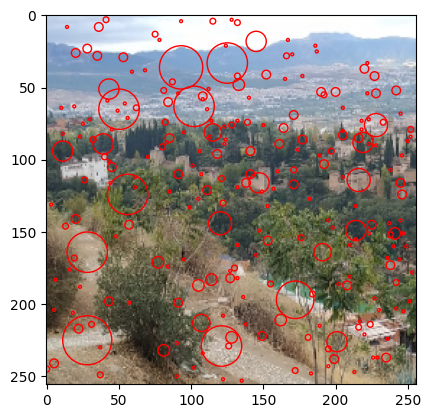

In [116]:
# Cargamos la imagen en color para poder dibujar sobre ella
im_color = readIm(get_image('IMG_20211030_110410_S.jpg'),1)

fig, ax = plt.subplots()

im_color = cv2.resize(im_color, (256, 256), cv2.INTER_LINEAR)

ax.imshow(im_color)

# Centramos en cada keypoint una circunferencia de radio variable en función de sigma
for i in range(len(kp_refined)):
  x = round(kp_refined[i][5])
  y = round(kp_refined[i][6])
  radius = int(1.5 * kp_refined[i][4])
  circle = plt.Circle((y, x), radius, color='r', fill=False)
  ax.add_patch(circle)

plt.show()


# 5. DESCRIPTOR DE KEYPOINTS

El descriptor de SIFT esta basado en una normalización respecto a una orientación de referencia. Como esta orientación de referencia vamos a usar el ángulo del gradiente local dominante. Primero lo calcularemos para posteriormente normalizar su distribución.

## 5.1 ORIENTACIÓN DE REFERENCIA DEL KEYPOINT

Usar la orientación dominante del gradiente permite la normalización de la orientación y por ello, la invarianza rotacional del descriptor. Para calcular esta orientación seguimos tres pasos:

###   HISTOGRAMA DE ORIENTACIÓN ACUMULADA

Dado un keypoint $(x,y,\sigma)$, la ventana donde se analiza es obtenida de la imagen $v^o_s$ del espacio de escalas. Teoricamente tomamos el entorno $W^{ori}$, como el conjunto de puntos $(m,n)$ de $v_s^o$ que satisfacen

$$
\text{max}\{|\delta_o m - x|,  |\delta_o n - y|\} \leq 3\lambda_{ori}\sigma
$$

Como la ventana no debe salirse de la imagen, descartamos los *keypoints* que están a una distancia menor de $3\lambda_{ori}\sigma$ de los bordes. Nuestro histograma cubrirá los valores $[0,2\pi]$ y estará compuesto de $n_{bins}$ celdas con centro $\theta_k = \frac{2\pi k}{n_{bins}}$.

Cada píxel $(m,n)$ en $W$ aportará al histograma un peso $c^{ori}_{m,n}$, el cual será el producto de la norma del gradiente con el peso gaussiano con desviación típica $\lambda_{ori}\sigma$ (por defecto $\lambda_{ori} = 1.5$) y centro $(x,y)$, esto dará más peso y, por tanto, más importancia a los píxeles más cercanos.

$$
c^{ori}_{m,n} = e^{-\frac{\| (m\delta_{o},n\delta_{o}) - (x,y) \|^{2}}{2(\lambda^{ori}\sigma)^{2}}} \| \left( \partial_{m} v^o_{s,m,n}, \partial_{n} v^o_{s,m,n}  \right) \|
$$

Este peso será añadido al histograma en la celda más cercana a la orientación del gradiente, esto es

$$
b^{ori}_{m,n} = \left[ \frac{n_{\text{bins}}}{2\pi} \left( \arctan2 \left( \partial_{m} v^o_{s,m,n}, \partial_{n} v^o_{s,m,n} \right) \right) \right]
$$

donde $[\cdot]$ representa la función de redondeo.

Por último, debemos tener en cuenta que calculamos el gradiente como diferencias finitas. En nuestro caso, convolucionamos con una máscara $[1,0,-1]/2$.


Definimos las funciones que calculan el gradiente y el histograma.

In [117]:
def gradientScaleSpace(scale_space, noct, nspo, mask = [-1/2,0,1/2], vert = True):
    """
    Calcula el espacio de escalas de gradientes para una imagen a partir de un espacio de escalas dado.

    Parámetros:
    - scale_space (list): Una lista de listas de imágenes. Cada sublista representa una octava
                          y contiene imágenes en diferentes escalas de esa octava.
    - noct (int): Número de octavas en el espacio de escala.
    - nspo (int): Número de escalas por octava en el espacio de escala.
    - mask (list): Una máscara unidimensional para calcular el gradiente. Por defecto es [-1, 0, 1]/2.
    - vert (bool): Un booleano que indica si la máscara debe aplicarse verticalmente. Si es Falso,
                   la máscara se aplicará horizontalmente.

    Retorna:
    - gradient_space (list): Un espacio de escala de gradientes correspondiente a cada imagen del
                             espacio de escala original.
    """

    ddepth = cv2.CV_64F
    gradient_space = []  # Inicializa el espacio de escala de gradientes

    # Itera a través de cada octava
    for o in range(noct):
        gradient_octave = []  # Inicializa la lista para los gradientes de la octava actual

        # Itera a través de cada escala dentro de la octava
        for s in range(nspo):
            # Define las máscaras para el filtro separable basado en 'vert'
            maskvert = mask if vert else [0, 1, 0]
            maskhori = [0, 1, 0] if vert else mask

            # Aplica el filtro separable a la imagen en la escala actual
            gradient_octave.append(cv2.sepFilter2D(scale_space[o][s], ddepth, kernelX=np.array(maskhori), kernelY=np.array(maskvert)))

        # Añade los gradientes de la octava actual al espacio de escala de gradientes
        gradient_space.append(gradient_octave)

    # Devuelve el espacio de escala de gradientes completo
    return gradient_space


In [118]:
def orientationHistogramAccumulation(gradient_img_x, gradient_img_y, x_key, y_key, threshold_dist, sigma_key, delta_o, nbins, lambda_ori=1.5):
    """
    Acumula un histograma de orientaciones basado en los gradientes de una imagen alrededor de un punto clave.

    Parámetros:
    - gradient_img_x (numpy.ndarray): Imagen de gradiente en la dirección x.
    - gradient_img_y (numpy.ndarray): Imagen de gradiente en la dirección y.
    - x_key (int): Coordenada x del punto clave en la imagen.
    - y_key (int): Coordenada y del punto clave en la imagen.
    - threshold_dist (int): Distancia umbral para definir el área alrededor del punto clave.
    - sigma_key (float): Desviación estándar asociada al punto clave.
    - delta_o (float): Distancia entre pixeles en la octava.
    - nbins (int): Número de divisiones en el histograma de orientación.
    - lambda_ori (float): Factor de escala para el cálculo del peso gaussiano, por defecto 1.5.

    Salida:
    - list: Histograma de orientaciones acumulado con las contribuciones de los gradientes.
    """

    # Inicializamos el histograma
    histogram = [0] * nbins

    # En la primera escala no podemos dividir por delta_o porque estamos multiplicando por 2 y nos salimos de la ventana
    #if(delta_o < 1):
    #  delta_o = 1

    # Inicializamos las coordenadas de la ventana
    m_min = round((x_key - threshold_dist) / delta_o)
    m_max = round((x_key + threshold_dist) / delta_o)
    n_min = round((y_key - threshold_dist) / delta_o)
    n_max = round((y_key + threshold_dist) / delta_o)

    #print('Tamaño imagen: ' + str(gradient_img_x.shape[0]) + 'x' + str(gradient_img_x.shape[1]))
    #print('M minimo: ' + str(m_min))
    #print('M maximo: ' + str(m_max))
    #print('N minimo: ' + str(n_min))
    #print('N minimo: ' + str(n_max))
    #print('delta_o: ' + str(delta_o))
    height = gradient_img_x.shape[0]
    width = gradient_img_x.shape[1]

    # Iteramos sobre la ventana de interés
    for m in range(m_min, m_max): # m_min ----> m_max
        for n in range(n_min, n_max): # n_min ----> n_max
          if 0 <= m < height and 0 <= n < width:
            #print('(m,n) = (' + str(m) + ',' + str(n) + ')' )
            # Calculamos la norma del gradiente en el punto (m, n)
            norm = np.sqrt(gradient_img_x[m][n]**2 + gradient_img_y[m][n]**2)
            # Calculamos la distancia ponderada por la función gaussiana
            dist_mn = ((m * delta_o - x_key)**2 + (n * delta_o - y_key)**2)
            c_mn = np.exp(-dist_mn / (2 * (lambda_ori * sigma_key)**2)) * norm

            # Calculamos la orientación correspondiente
            mod = mt.fmod(mt.atan2(gradient_img_y[m][n], gradient_img_x[m][n]), 2 * np.pi)
            b_mn = round((nbins / (2 * np.pi)) * mod)

            # Acumulamos en el histograma
            histogram[b_mn] += c_mn

    return histogram

### SUAVIZADO DEL HISTOGRAMA

En este paso simplemente realizamos un número de veces (6 en nuestro caso) una convolución circular con una máscara de suavizado

$$[1,1,1]/3$$

Definimos esta función.

In [119]:
def smoothHistogram(histogram, mask=[1/3, 1/3, 1/3], ntimes=6):
  """
  Suaviza un histograma aplicando una convolución circular con una máscara especificada.
  Este proceso se repite un número determinado de veces.

  Parámetros:
    - histogram (list o np.array): Histograma que se va a suavizar.
    - mask (list o np.array, opcional): Máscara (o kernel) que se utilizará para la convolución.
      Por defecto, es [1, 1, 1]/3, que representa un promedio simple sobre tres puntos consecutivos.
    - ntimes (int, opcional): Número de veces que se aplicará la convolución al histograma.
      Por defecto, es 6.

  Salida:
    - list o np.array: Histograma suavizado después de aplicar la convolución n veces.
  """

  padded_histogram = histogram

  for i in range(ntimes):
    # Agrega el primer y último elemento al final y al inicio del histograma, respectivamente, para realizar una convolución circular
    # Es necesario actualizar los bordes en cada iteración para que realmente sea una covolcuión circular
    padded_histogram.append(padded_histogram[0]) # Añadimos el priumer elemento al final de la lista
    padded_histogram.insert(0, padded_histogram[-2]) # En -2 está el útimo elemento de histogram actualizado

    # Aplica la convolución al histograma modificado con la máscara especificada
    # Al aplicar 'valid' se eliminan los bordes
    padded_histogram = np.convolve(padded_histogram, mask, 'valid')

  return padded_histogram


### EXTRACCIÓN DE ORIENTACIONES DE REFERENCIA

Seleccionamos las orientaciones de referencia desde el histograma suavizado. Nos quedamos con aquellas orientaciones que sean mayores que $t$ veces el máximo del histograma (por defecto tomamos $t=0.8$), por lo tanto, el número de descriptores puede sobrepasar al número de *keypoints*.

Sea $k\in \{1,...,n_{bins} \}$ el índice de una celda tal que $h_k>h_{k^-}$, $h_k>h_{k^+}$, donde $k^-=(k-1)$ mod  $n_{bins}$ y $k^+=(k+1)$ mod  $n_{bins}$. Esto es, que sea mayor que sus dos vecinos y, para lidiar con los bordes y hacer el histograma circular, consideramos el módulo con $n_{bins}$.

Además, exigimos que $h_k \geq t\text{max}(h)$. Esta celda está centrada en la orientación $\theta_k = \frac{2\pi(k-1)}{n_{bins}}$ y la orientación de referencia $\theta_{ori}$ será calculada como el máximo de la función cuadrática que interpola los valores $h_{k^-}$, $h_k$ y $h_{k^+}$

$$
\theta_{ref} = \theta_k + \frac{\pi}{n_{bins}} \left( \frac{h_{k^-} - h_{k^+}}{h_{k^-} 2h_k + h_{k^+}} \right)
$$

Hemos resumido el proceso de obtener los polinomois de Lagrange de orden 2, calcular la interpolación y obtener el máximo depejando la derivada igualada a $0$.

Cada una de estas orientaciones de referencia da lugar a un descriptor local en un vecindario del *keypoint*.

Definimos la función.

In [120]:
def referenceOrientationExtraction(histogram, nbins, t_value=0.8):
    """
    Extrae las orientaciones de referencia a partir de un histograma.

    Parámetros:
    - histogram (list): Lista que representa el histograma de orientaciones.
    - nbins (int): Número de divisiones en el histograma.
    - t_value (float): Valor umbral para seleccionar picos significativos en el histograma.
                      Por defecto, es 0.8.

    Retorna:
    - referenceOrientations (list): Lista de orientaciones de referencia extraídas del histograma.
    """

    referenceOrientations = []  # Inicializa la lista para almacenar las orientaciones de referencia
    h_max_index = np.argmax(histogram)  # Encuentra el índice del valor máximo en el histograma
    h_max = histogram[h_max_index]  # Obtiene el valor máximo en el histograma


    # Itera a través de cada bin en el histograma
    for i in range(nbins):
        # Verifica si el bin actual tiene un valor más alto que sus vecinos y está por encima del umbral
        if (histogram[i] > histogram[i - 1]
            and histogram[i] > histogram[(i + 1) % nbins]
            and histogram[i] > t_value * h_max):
            # Calcula la orientación de referencia utilizando la interpolación
            referenceOrientations.append(
                np.pi / nbins * (2 * (i - 1) + (histogram[i - 1] - histogram[(i + 1) % nbins]) / (histogram[i - 1] - 2 * histogram[i] + histogram[(i + 1) % nbins]))
            )

    return referenceOrientations


### FUNCIÓN GENERAL

Ahora podemos crear la función global que se encarga de obtener para cada *keypoint* sus orienteaciones de referencia, si es que es posible.

In [121]:
def mostrarHistograma(data):
  # Creamos un histograma a partir de la lista de datos
  plt.hist(data, bins=10, alpha=0.7, color='blue')

  # Añadimos títulos y etiquetas para mayor claridad
  plt.title('Histograma de la lista de datos')
  plt.xlabel('Valor')
  plt.ylabel('Frecuencia')

  # Mostramos la gráfica
  plt.show()

In [122]:
def keypointReferenceOrientation(scale_space, scale_space_gradient_x, scale_space_gradient_y, keypoints, lambda_ori=1.5, nbins=36):
    """
    Calcula las orientaciones de referencia para  los keypoints en un espacio de escalas.

    Parámetros:
    - scale_space_gradient_x (list): Lista de gradientes en la dirección x en el espacio de escalas.
    - scale_space_gradient_y (list): Lista de gradientes en la dirección y en el espacio de escalas.
    - keypoints (list): Lista de keypoints, cada uno representado como una tupla con información específica.
    - lambda_ori (float): Parámetro lambda para el cálculo de orientaciones.
    - nbins (int): Número de divisiones en el histograma.

    Retorna:
    - referenceOrientations (list): Lista de orientaciones de referencia para cada keypoint.
    """

    reference_orientations_kp = []  # Inicializa la lista para almacenar las orientaciones de referencia
    downsampling_factor = 2  # Factor de muestreo para downsampling

    # Itera a través de cada keypoint
    for kp in keypoints:
        o = kp[0]  # Octava del keypoint
        s = kp[1] - 1  # Escala del keypoint, recordemos que las escalas van de 1 a 3 porque la primera y la ultima no la consideramos
        sigma_key = kp[4]  # Sigma del keypoint
        x_key = kp[5]  # Coordenada x del keypoint
        y_key = kp[6]  # Coordenada y del keypoint

        if(s == 0):
          print('o: ' + str(o))
          print('s: ' + str(s))

        #print('n oct: ' + str(len(scale_space_gradient_x)))
        #print('n spo: ' + str(len(scale_space_gradient_x[0])))

        # Obtiene la imagen, gradientes en x e y para el keypoint actual
        img = scale_space[o][s]
        gradient_img_x = scale_space_gradient_x[o][s]
        gradient_img_y = scale_space_gradient_y[o][s]

        # Dimensiones de la imagen
        height = gradient_img_x.shape[0]
        width = gradient_img_x.shape[1]

        # Distancia de umbral para verificar si el keypoint está lo suficientemente lejos de los bordes
        threshold_dist = 3 * lambda_ori * sigma_key
        delta_o = downsampling_factor ** (o - 1)

        hist_cont = 0

        # Comprobar que el keypoint está lo suficientemente lejos de los bordes
        if (
            (threshold_dist <= x_key and x_key  <= (height - threshold_dist))
            and (threshold_dist <= y_key and y_key <= (width - threshold_dist))
        ):
            # A. HISTOGRAMA DE ORIENTACIÓN ACUMULADA
            histogram = orientationHistogramAccumulation(
                gradient_img_x, gradient_img_y, x_key, y_key, threshold_dist, sigma_key, delta_o, nbins, lambda_ori
            )

            # B. SUAVIZADO DEL HISTOGRAMA
            # HE CAMBIADO EL SMOOTH HISTOGRAMA !!!!!!!!!!!!!!
            histogram = smoothHistogram_corregido(histogram)

            #if(hist_cont < 100):
              #mostrarHistograma(histogram)
              #hist_con = hist_cont + 1

            # C. EXTRACCIÓN DE ORIENTACIONES DE REFERENCIA
            references_orientations = referenceOrientationExtraction(histogram, nbins, 0.8)

            #if(hist_cont < 100):
              #for ori in references_orientations:
                #print(ori)

            # Añadimos las orientaciones de referencia junto con su kp correspondiente a la lista
            for theta_ref in references_orientations:
              reference_orientations_kp.append((o,s,sigma_key,x_key,y_key, theta_ref))

    # Retorna la lista de orientaciones de referencia para todos los keypoints
    return reference_orientations_kp

In [123]:
def gradientScaleSpace_corregido(scale_space, noct, nspo, mask=[-1/2, 0, 1/2], vert=True):
    ddepth = cv2.CV_64F
    gradient_space = []

    for o in range(noct):
        gradient_octave = []

        for s in range(nspo):
            # Convertir la máscara en un array de NumPy y asegurarse de que es un vector fila
            mask_np = np.array(mask, dtype=float).reshape(1, -1)

            # Crear kernels como vectores columna o fila
            if vert:
                maskvert = mask_np.T  # Transponer para obtener un vector columna
                maskhori = np.array([[0, 1, 0]], dtype=float)
            else:
                maskvert = np.array([[0], [1], [0]], dtype=float)
                maskhori = mask_np  # Usar como vector fila

            # Aplicar el filtro separable
            gradient_octave.append(cv2.sepFilter2D(scale_space[o][s], ddepth, kernelX=maskhori, kernelY=maskvert))

        gradient_space.append(gradient_octave)

    return gradient_space

In [124]:
def smoothHistogram_corregido(histogram, mask=[1/3, 1/3, 1/3], ntimes=6):
    # ESTO Lastra decía que era el mayor crimen que se podía cometer programando (Sé que eres Nasr)
    if isinstance(histogram, list):
        histogram = np.array(histogram)  # Convierte el histograma en un array de NumPy si es una lista

    for i in range(ntimes):
        # Añade el primer y último elemento al final y al inicio del histograma para una convolución circular
        padded_histogram = np.pad(histogram, (1, 1), mode='wrap')

        # Aplica la convolución al histograma modificado con la máscara especificada
        histogram = np.convolve(padded_histogram, mask, 'valid')

    return histogram

In [125]:
type(scale_space), type(scale_space[0]), len(scale_space), len(scale_space[0])

(list, list, 5, 6)

In [126]:
scale_space_gradient_x = gradientScaleSpace_corregido(scale_space, 5, 3, [-1/2,0,1/2],False)
scale_space_gradient_y = gradientScaleSpace_corregido(scale_space, 5, 3, [-1/2,0,1/2],True)

In [127]:
kp_orientations =  keypointReferenceOrientation(scale_space, scale_space_gradient_x, scale_space_gradient_y, kp_refined, 1.5, 36)

o: 0
s: 0
o: 0
s: 0
o: 1
s: 0


## 5.2 DESCRIPTOR DE NORMALIZACIÓN DEL KEYPOINT

El descriptor SIFT codifica la distibución espacial local del gradiente de la orientación de un *keypoint* en un entorno dado. El entorno normalizado respecto a este *keypoint* consiste en una ventana cuadrada con centro las coordenadas del *keypoint* y alineado con la orientación de referencia de este, $\theta_{ref}$.

El descriptor consiste en un conjunto de histogramas ponderados calculados en diferentes regiones del entorno normalizado. Vamos a desglosar el procedimiento.

### ENTORNO NORMALIZADO

Para cada *keypoint* $(x_{key}, y_{key}, \sigma_{key}, \theta_{key})$, tenemos una ventana en una octava $o$ y escala $s$. Un punto de esta imagen $v^o_s$, de coordenadas $(x_{m,n}, y_{m,n}) = (m\delta_o, n\delta_o)$ en la imagen original, tiene coordenadas normalizadas
$(\hat{x}_{m,n} , \hat{y}_{m,n})$ con respecto al *keypoint* $(x_{key}, y_{key}, \sigma_{key}, \theta_{key})$,


$$
\hat{x}_{m,n} =
\left< (\delta_o(m,n)-(x,y) , (\text{cos}\theta_{key}, \text{sen}\theta_{key})) \right> / \sigma_{key} = \\
((m\delta_o - x_{key}) \text{cos } \theta_{key} + (n\delta_o - n_{key}) \text{sin } \theta_{key})/ \sigma_{key}
$$


$$
\hat{y}_{m,n} =
\left< (\delta_o(m,n)-(x,y) , (-\text{sen}\theta_{key}, \text{cos}\theta_{key})) \right> / \sigma_{key} =\\
(-(m\delta_o - x_{key}) \text{sin } \theta_{key} + (n\delta_o - n_{key}) \text{cos } \theta_{key})/ \sigma_{key}
$$

Como tal, estamos considerando el vector $\delta_o(m,n)-(x,y)$, con origen en el keypoint y final en el punto de la imagen original y lo estamos proyectando sobre los vectores ortonormales $(\text{cos}\theta_{key}, \text{sen}\theta_{key})$ y $(-\text{sen}\theta_{key}, \text{cos}\theta_{key})$. Es decir, estamos haciendo un cambio de base. Además, lo normalizamos por la desviación típica $\sigma_{key}$.

La ventana normalizada, denotada como $W^{descr}$ es el conjunto de píxeles $(n,m)$ de $v^o_s$ con coordenadas normalizadas $(\hat{x}_{m,n}, \hat{y}_{m,n})$ cunpliendo

$$
\text{max}\{ | \hat{x}_{m,n} |, | \hat{y}_{m,n}| \} \leq \lambda_{descr}
$$

Los *keypoints* a una distancia del borde menor que $\sqrt{2}\lambda_{descr}\sigma$ se descartan ya que, si consideramos todas las orientaciones posibles, la que nos da una mayor distancia en el eje vertical y horizontal es $k\frac{\pi}{4}(2k+1)$ con $k \in \mathbb{Z}$ , en concreto, si consideramos la distancia horizontal del centro del entorno a su frontera cuando este no esta alineado con la orientación de referencia, si orientamos este a la orientación que acabamos de definir, nos da un factor de porporción de $\sqrt{2}$. Esto se puede ver facilmente orientando un cuadrado unidad $\frac{\pi}{4}$ radianes y comparando la norma-$2$ de sus ejes horizontales.

Cada punto $(m,n)$ estará caracterizado por la orientación del gradiente normalizada respecto a la orientación $\theta_{key}$, es decir, queremos asignar a cada punto su orientación relativa a la orientación de referencia. Esto es

$$
\hat{\theta}_{m,n} = \text{atan2}(\partial_m v^o_{s,m,n}, \partial_n v^o_{s,m,n}) - \theta_{key} \quad \text{mod } 2\pi
$$

La contribución al histograma de este píxel será $c^{descr}_{m,n}$, definida como el producto de la norma del gradiente y el peso Gaussiano de centro las coordenadas del *keypoint* y desviación típica $\lambda_{descr}\sigma_{key}$, reduciendo así la contribución de los píxeles más distantes al centro.

$$
c^{ori}_{m,n} = e^{-\frac{\| (m\delta_{o},n\delta_{o}) - (x,y) \|^{2}}{2(\lambda_{descr}\sigma)^{2}}} \| \left( \partial_{m} v^o_{s,m,n}, \partial^{vo}_{n} v^o_{s,m,n}  \right) \|
$$

### HISTOGRAMA DE VECTORES DE ORIENTACIÓN

La orientación del gradiente de cada xel en la ventana normalizada  es acumulado en una vector de orden $n_{hist} \times n_{hist}$, en realidad, es una matriz de este orden vectorizada (por defecto usaremos $n_{hist} = 4$). Cada uno de estos histogramas, denotados por $h^{i,j}$ con $(i,j) \in \{ 1,...,n_{hist}\}^2$, tiene una posición asociada con respecto al *keypoint* $(x_{key}, y_{key}, \sigma_{key}, \theta_{key})$ dado por

$$
\hat{x}^i = \left( i - \frac{1+n_{hist}}{2} \right) \frac{2\lambda_{descr}}{n_{hist}}, \quad
\hat{y}^i = \left( j - \frac{1+n_{hist}}{2} \right) \frac{2\lambda_{descr}}{n_{hist}}
$$

Cada histograma $h^{i,j}$ consiste en $n_{ori}$ celdas $h_k^{i,j}$ con $k \in \{1,..., n_{ori} \}$, centrado en $\hat{\theta}^k = 2\pi(k-1)/n_{ori}$ (por defecto tomaremos $n_{ori} = 8$). Cada punto $(m,n)$ en el entorno normalizado $W^{descr}$ contribuye a los histogramas más cercanos (hasta 4). La contribución total $c^{descr}_{m,n}$ de cada punto es dividida bilinealmente sobre los 4 histogramas dependiendo de la distancia a cada uno.

De la misma manera la contribución dentro de cada histograma es dividida entre las dos celdas más cercanas.

Esto hace que, fijando un punto $(m,n)$, se tenga para cada $(i,j,k) \in \{ 1,..., n_{hist}\}^2 \times {1,..., n_{ori}}$ cumpliendo

$$
| \hat{x}^i - \hat{x}_{m,n}| \leq \frac{2\lambda_{descr}}{n_{hist}}, \quad
| \hat{y}^i - \hat{y}_{m,n}| \leq \frac{2\lambda_{descr}}{n_{hist}} \quad y \quad
|\hat{\theta}^k - \hat{\theta}_{m,n}| \quad \text{mod } 2\pi \leq \frac{2\pi}{n_{ori}}
$$

el histograma $h_k^{i,j}$ es actualizado por

$$
h_k^{i,j} \longleftarrow h_k^{i,j} +
\left(1 - \frac{n_{hist}}{2\lambda_{descr}} | \hat{x}^i - \hat{x}_{m,n} | \right)
\left(1 - \frac{n_{hist}}{2\lambda_{descr}} | \hat{y}^i - \hat{y}_{m,n} | \right)
\left(1 - \frac{n_{ori}}{2\pi} \left| \hat{\theta}^k - \hat{\theta}_{m,n}  \quad \text{mod } 2\pi \right| \right)
c^{descr}_{m,n}
$$

### VECTOR DE DESCRIPTORES DE SIFT

Por último, definimos un vector de características $f$ de longitud $n_{hist} \times n_{hist} \times n_{ori}$ como

$$
f_{(i-1)n_{hist}n_{ori}+(j-1)n_{ori}+k} = h_k^{i,j}
$$

donde $i\in\{ 1,...,n_{hist}\}$, $j\in\{ 1,...,n_{hist}\}$ y $k\in\{ 1,...,n_{ori}\}$. Las componentes del vector de características $f$ son saturadas a un valor máximo del $20%$ de su norma Euclidiana, esto es

$$
f_k \leftarrow \text{min}(f_k, 0.2\|f\|)
$$

El principal motivo de esta saturación es reducir el impacto de cambios de iluminación no lineales, como regiones saturadas.

Por último se normaliza el vector de forma que $\| f\|_2 = 512$ y ¿cuantizado? a enteros de 8 bits, esto es

$$
f_k \leftarrow \text{min}(\lfloor f_k \rfloor, 255)
$$

La cuantización pretende acelerar el cálculo de la distancias entre diferentes vectores de características.

In [128]:
def keypointDescriptor(scale_space, scale_space_gradient_x, scale_space_gradient_y, keypoints, lambda_descr = 6):
    """
    Calcula las orientaciones de referencia para  los keypoints en un espacio de escalas.

    Parámetros:
    - o_key(int): Octava en la que se ha encontrado el keypoint
    - s_key(int): Escala dentro de la octava en la que está el keypoint
    - x_key (int): Posición en el eje x del keypoint
    - y_key (int): Posición en el eje y del keypoint
    - sigma_key (float): Sigma acumulado de la imagen en la que se encuentra el keypoint
    - theta_key (float): orientación de referencia del keypoint

    Retorna:
    - feature_vector (list): descriptor del keypoint
    """
    nhist = 4 # valor por defecto
    nori = 8  # valor por defecto
    t = 0.8           # threshold estándar a la hora de buscar una segunda orientación de referencia
    downsampling_factor = 2  # Factor de muestreo para downsampling

    descriptor = []

    for kp in keypoints:
      feature_vector = []

      o = kp[0]  # Octava del keypoint
      s = kp[1]  # Escala del keypoint
      sigma_key = kp[2]  # Sigma del keypoint
      x_key = kp[3]  # Coordenada x del keypoint
      y_key = kp[4]  # Coordenada y del keypoint
      theta = kp[5]   # Orientación preferente del keypoint

      # Obtiene la imagen, gradientes en x e y para el keypoint actual
      img = scale_space[o][s]
      gradient_img_x = scale_space_gradient_x[o][s]
      gradient_img_y = scale_space_gradient_y[o][s]

      # Dimensiones de la imagen
      height = gradient_img_x.shape[0]
      width = gradient_img_x.shape[1]

      # Distancia de umbral para verificar si el keypoint está lo suficientemente lejos de los bordes
      threshold_dist = np.sqrt(2) * lambda_descr * sigma_key
      delta_o = downsampling_factor ** (o - 1)
      #if(delta_o < 1):
      #  delta_o = 1

      if (
            (threshold_dist <= x_key <= (height - threshold_dist))
            and (threshold_dist <= y_key <= (width - threshold_dist))
        ):

          # Inicializamos el histograma (i,j)
          histogram = [[[0 for _ in range(nori)] for _ in range(nhist)] for _ in range(nhist)]
          # manera alternativa por si esto no va np.zeros((nhist, nhist, nori))

          c = (nhist+1)/nhist
          # Inicializamos las coordenadas de la ventana
          m_min = round((x_key - threshold_dist*c) / delta_o)
          m_max = round((x_key + threshold_dist*c) / delta_o)
          n_min = round((y_key - threshold_dist*c) / delta_o)
          n_max = round((y_key + threshold_dist*c) / delta_o)

          # Iteramos sobre la ventana de interés
          for m in range(m_min, m_max): # m_min ----> m_max
            for n in range(n_min, n_max): # n_min ----> n_max
              #COMPROBACION QUE NO SE SI DEBERÍAMOS DE PONER
              if 0 <= m < height and 0 <= n < width:
                # Calculamos las coordenadas normalizadas
                x_norm = ((m*delta_o - x_key)*mt.cos(theta) + (n*delta_o - y_key)*mt.sin(theta))/sigma_key
                y_norm = (-(m*delta_o - x_key)*mt.sin(theta) + (n*delta_o - y_key)*mt.cos(theta))/sigma_key

                # Comprobamos que la muetra (m,n) se encuentra dentro de la ventana normalizada
                if(max(abs(x_norm), abs(y_norm)) < lambda_descr*c):
                  # Calculamos la orientación del gradiente normalizada
                  theta_norm = mt.fmod(mt.atan2(gradient_img_y[m][n], gradient_img_x[m][n]) - theta, 2 * np.pi)

                  # Calculamos la contribución
                  norm = np.sqrt(gradient_img_x[m][n]**2 + gradient_img_y[m][n]**2)
                  dist_mn = ((m * delta_o - x_key)**2 + (n * delta_o - y_key)**2)
                  c_mn_d = np.exp(-dist_mn / (2 * (lambda_descr * sigma_key)**2)) * norm

                  for i in range(nhist):
                    for j in range(nhist):
                      x_norm_i = (i - (1+nhist)/2)*(2*lambda_descr / nhist)
                      y_norm_j = (j - (1+nhist)/2)*(2*lambda_descr / nhist)
                      if( abs(x_norm_i - x_norm) <= ((2*lambda_descr)/nhist) and abs(y_norm_j - y_norm) <= ((2*lambda_descr)/nhist)):
                        for k in range(nori):
                          theta_norm_k = 2*np.pi * (k-1) / nori
                          if( abs(mt.fmod(theta_norm_k - theta_norm, 2 * np.pi)) <= ((2 * np.pi)/nori) ):
                            histogram[i][j][k] = histogram[i][j][k] + (1 - (nhist/2*lambda_descr)*abs(x_norm - x_norm_i))*(1 - (nhist/2*lambda_descr)*abs(y_norm - y_norm_j))*( 1 - (nori/2*np.pi)*abs( mt.fmod(theta_norm - theta_norm_k, 2*np.pi) ) )*c_mn_d

          histogram_array = np.array(histogram)
          #feature_vector = histogram_array[1:-1, 1:-1, :].flatten()
          feature_vector = histogram_array.flatten()

          for l in range(nhist*nhist*nori):
            f_norm = np.linalg.norm(feature_vector)
            feature_vector[l] = min(feature_vector[l], 0.2*f_norm)
            if f_norm != 0:
              feature_vector /= np.linalg.norm(feature_vector)
              feature_vector = (512 * feature_vector).clip(0, 255).round()
            feature_vector[feature_vector < 0] = 0
            feature_vector[feature_vector > 255] = 255

          descriptor.append((o, s, x_key, y_key, sigma_key, theta, feature_vector))

    return descriptor


In [129]:
descriptors= keypointDescriptor(scale_space, scale_space_gradient_x, scale_space_gradient_y,kp_orientations , 6)

In [130]:
len(kp_refined), len(descriptors)

(244, 235)

# Función final

In [131]:
def detectandcompute(im, noct=5, nspo=3):
  scale_space = scaleSpace(im)
  laplacian_space = laplacianSpace(scale_space)
  kp = LaplacianExtrema(laplacian_space, len(scale_space), len(scale_space[0]))
  kp_lowcontrast = lowContrastExtremaSupression(laplacian_space, kp)
  kp_noedge = edgeExtremaSupression(laplacian_space, kp_lowcontrast)
  kp_refined = posRefinement(laplacian_space,kp_noedge)

  scale_space_gradient_x = gradientScaleSpace_corregido(scale_space, noct, nspo, [-1/2,0,1/2],False)
  scale_space_gradient_y = gradientScaleSpace_corregido(scale_space, noct, nspo, [-1/2,0,1/2],True)

  kp_orientations = keypointReferenceOrientation(scale_space, scale_space_gradient_x, scale_space_gradient_y, kp_refined, 1.5, 36)
  print(len(kp_orientations))
  kp_descriptor = keypointDescriptor(scale_space, scale_space_gradient_x, scale_space_gradient_y, kp_orientations, 6)

  final_kp = [cv2.KeyPoint(float(i[2]), float(i[3]), i[4], i[5]) for i in kp_descriptor]
  final_desc = [i[6] for i in kp_descriptor]


  return final_kp, final_desc

In [132]:
final_kp, final_descr = detectandcompute(im)

o: 0
s: 0
o: 0
s: 0
o: 1
s: 0
248


In [133]:
len(final_kp),  len(final_descr)

(235, 235)

In [134]:
sift = cv2.SIFT_create()
libreria_kp, libreria_descr = sift.detectAndCompute(im,None)

In [135]:
len(libreria_kp), len(libreria_descr)

(830, 830)

In [136]:
print(libreria_kp[0]), print(final_kp[0]), print(final_descr[20]), print(libreria_descr[9])

< cv2.KeyPoint 0x7a3ad971ae50>
< cv2.KeyPoint 0x7a3ad998ea60>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[  8.  46.  14.   5.   4.  21.  14.   2.  29.  58.  19.   9.   1.  11.
  50.  57.  90.  98.   2.   0.   0.   0.  14.  92.  61.  53.   7.   3.
   6.   2.   0.  16.   8.  68.  76.  18.   1.   0.   0.   0.  24. 100.
 137.  50.   2.   1.   1.   6. 137. 137.  27.   1.   0.   0.   0.  19.
  51.  63.  25.  13.   3.   0.   0.   8.   2.  68.  59.  21.  14.   3.
   0.   0.  98.  25.  34.  25.   5.   2.   8.  91. 137.  23.   4.   1.
   0.   0.   3. 137.  52.   2.   2.  11.  24.  11.   3.  31.  16.  36.
  19.   4.  35.  19.   0.   0. 137.  55.   6.   0.

(None, None, None, None)

In [137]:
def siftPoints(im,nfeatures=5000):
  # To be completed by the students
  sift = cv2.SIFT_create()
  kp, ds = sift.detectAndCompute(im,None)

  kp = sorted(kp, key=lambda x: -x.response)
  if len(kp) > nfeatures:
    kp = kp[:nfeatures]
  kp, ds = sift.compute(im, kp)

  return kp,ds

In [141]:
comparar_l_sift, _ = siftPoints(im, 235)

In [142]:
def showKP(im,kp,title):
  img=cv2.drawKeypoints(im, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  displayIm(img,title,1)

In [147]:
print(kp_refined)

[[0, 2, 7, 231, 1.4055023540902736, 3.5694300046444396, 115.2443421649463, 0.11638263595064223], [0, 2, 6, 257, 1.3276956719791018, 2.9254210918713275, 128.41839475978276, 0.09954758835797725], [0, 2, 7, 81, 1.449494839035272, 3.3343935905966267, 40.50002742181523, 0.9940381290982739], [0, 2, 8, 187, 1.1732996412732561, 3.98117462491414, 93.3673417395779, 0.24450786999661034], [0, 2, 10, 263, 1.4416623272237628, 5.146345102053226, 131.7264846363047, -0.15349164337723056], [0, 2, 16, 29, 1.122234399290165, 7.955852408884242, 14.385979879528236, -1.0374510973703068], [0, 2, 26, 150, 1.3342301410927067, 12.758256458704867, 75.18364016170122, -0.87376070779181], [0, 2, 33, 156, 1.2988777666232234, 16.52705539739633, 77.72066072560551, 1.485286090133564], [0, 2, 33, 335, 1.2211917396232488, 16.51750620366969, 167.36752259684542, -4.298520498023347], [0, 2, 41, 248, 1.1110735525973672, 20.56474469310324, 123.83134465096812, -4.677476414407222], [0, 2, 43, 371, 1.2605667969574492, 21.38966934

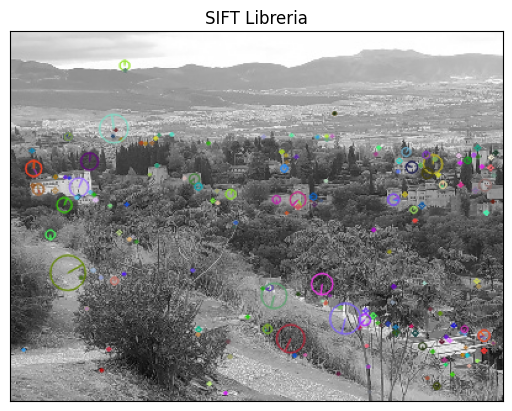

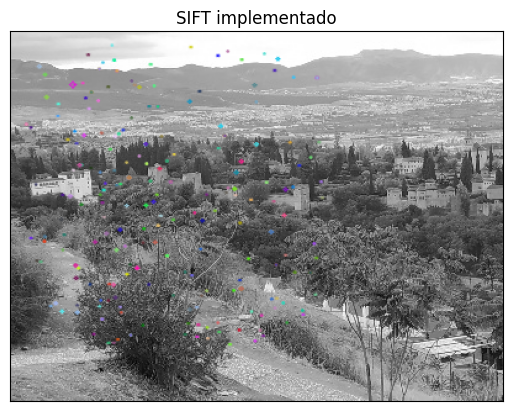

In [148]:
showKP(im, comparar_l_sift, 'SIFT Libreria')
showKP(im, final_kp, 'SIFT implementado')

# 6. BAG OF WORDS

DIAP 3.3 20 - 28,  - ,

